# Hyperparameter Search

Author: Shanel Gauthier
Date: 2021-12-09

The objective of this notebook is to train muliple models and compare their performance. 

For each architecture, a simple hyperparameter search is performed.

In order to run the parametric scttaring network, you need to clone the repository below.

In [ ]:
#clone parametric scattering network repo
#! git clone https://github.com/sgaut023/kymatio_mod/

Cloning into 'kymatio_mod'...
remote: Enumerating objects: 9863, done.
remote: Counting objects: 100% (2185/2185), done.
remote: Compressing objects: 100% (767/767), done.


In [27]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from getpass import getpass
from sklearn.metrics import classification_report
from torchvision import models
from pprint import pprint
from pathlib import Path 
from sklearn.model_selection import ParameterSampler

import time
import sys
import torch.nn as nn
import pandas as pd
import IPython
import numpy as np
import seaborn as sn
import mlflow
import os
import sys
import matplotlib.pyplot as plt
import sklearn.utils.class_weight as class_weight
import datetime
import copy
import timm
import warnings

In [2]:
sys.path.append(str(Path.cwd().parent)+'/kymatio_mod')
sys.path.append(str(Path.cwd().parent))

In [3]:
# import kymatio classes
sys.path.append(str(Path.cwd().parent))
from kymatio_mod.parametricSN.models.sn_base_models import sn_ScatteringBase
from kymatio_mod.parametricSN.models.sn_top_models import sn_LinearLayer,sn_CNN
from kymatio_mod.parametricSN.models.sn_hybrid_models import sn_HybridModel
warnings.filterwarnings("ignore")

# 1. Experimental Tracking Tool

For this experiment, we are using an experimental tracking tool called Mlflow.

The metrics are saved in the DAGsHub's servers. Click [here](https://dagshub.com/gauthier.shanel/skin_disease/experiments/#/) to see the hyperparameter search results.

To run this notebook and save your results [here](https://dagshub.com/gauthier.shanel/skin_disease/experiments/#/), you need to create

**Set Environment Variables**

In [4]:
#@title Enter the repository name for the project:

REPO_NAME= "skin_disease" #@param {type:"string"}

In [5]:
#@title Enter the repository name for the project:

REPO_OWNER= "gauthier.shanel" #@param {type:"string"}

In [6]:
#@title Enter the username of your DAGsHub account:

USER_NAME = "gauthier.shanel" #@param {type:"string"}

**Set Local Configurations**

Under the [Token tab](https://dagshub.com/user/settings/tokens) in the user setting, copy the default token and use it here.

In [8]:
os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

Enter your DAGsHub access token or password:  ········································


# 1. Create Pytorch Dataset

In this section, we create the pytorch Dataset and dataloader.

In [9]:
#Settings and hyperparamerters for this experiment
workers = 4
batch_size=16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def augmentationFactory(augmentation):

  if augmentation == 'augment':
        transform = [
            transforms.Resize((400,400)),
            transforms.RandomHorizontalFlip(),
        ]

  elif augmentation == 'noaugment':
          transform = [
            transforms.Resize((400,400)),
        ]

  else: 
      NotImplemented(f"augment parameter {augmentation} not implemented")

  normalize = transforms.Normalize(mean=[0.6475, 0.4907, 0.4165],
                                     std=[0.1875, 0.1598, 0.1460])

  return transforms.Compose(transform + [transforms.ToTensor()])                 #, normalize])       


In [11]:
# Create Dataset
dataset = datasets.ImageFolder(root='data_3class_skin_diseases/', transform=augmentationFactory('augment'))

In the dataloader, we normalize the images by the mean and std per channel. Below, you can see how we computed the mean and std per channel.

Mean: [0.6475, 0.4907, 0.4165]
std: [0.1875, 0.1598, 0.1460]

In [12]:
# code from: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def get_mean_std_per_channel(loader):
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages
    return mean, std
# create dataloader
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)
get_mean_std_per_channel(loader)

(tensor([0.6475, 0.4907, 0.4165]), tensor([0.1882, 0.1607, 0.1470]))

# 2. Training Utils

In this section, we implement the functions that will be used to train de different models.

In [13]:
def get_loaders(dataset, train_ids, test_ids, batch_size):
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader( dataset,batch_size=batch_size, sampler=test_subsampler)
  return trainloader, testloader, train_subsampler

In [14]:
def get_loss_function(dataset, trainloader, indices):
  #Compute class weight of the classes
  class_weights=class_weight.compute_class_weight('balanced', classes= np.unique(dataset.targets), 
                                                  y = np.array(trainloader.dataset.targets)[indices] )
  class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
  return nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

In [15]:
def get_confusion_matrix(y_true, y_pred):
  matrix = confusion_matrix(y_true, y_pred)
  index = np.arange(0, len(matrix), 1)
  df_cm = pd.DataFrame(matrix, index=index, columns=index)
  f = plt.figure()
  sn.heatmap(df_cm, annot=True)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [16]:
def visualize_loss(train_loss, test_loss):
  f = plt.figure(figsize=(7,5))
  epochs = np.arange(0, len(train_loss))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot( epochs, train_loss, label='Train' )
  plt.plot( epochs, test_loss, label= 'Test' )
  plt.legend()
  plt.show()

In [17]:
def evaluate_model(network, testloader, loss_function):
  correct, total = 0, 0
  with torch.no_grad():

    y_pred = []
    y_true = []
    for i, data in enumerate(testloader, 0):

      # Get inputs
      inputs, targets = data
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Generate outputs
      outputs = network(inputs)
      loss = loss_function(outputs, targets)  

      # Set total and correct
      _, predicted = torch.max(outputs.data, 1)
      y_pred.extend(predicted.cpu().numpy())
      y_true.extend(targets.cpu().numpy())
  return loss, y_pred, y_true

In [18]:
def save_results(results, fold, y_pred, y_true):  
  results[fold]={}
  results[fold]['pred'] = y_pred
  results[fold]['label']= y_true
  results[fold]['classification_report']=classification_report(y_true, y_pred, output_dict=True)

In [19]:
def setAllSeeds(seed):
    """Helper for setting seeds"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [20]:
def train_model(name, dataset, k_folds =5, num_epochs =15, lr =1e-4, random_state=42, batch_size=16):
  # code isnpired from: https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
  setAllSeeds(random_state)
  kfold = StratifiedKFold(n_splits=k_folds, shuffle = True, random_state=random_state)
  results = {}
  start_time = time.time()
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset.targets)):
      print(f'FOLD {fold}')
      print('--------------------------------')
      network = get_model(name)
      network.to(device)
      trainloader, testloader, train_subsampler =get_loaders(dataset, train_ids, test_ids, batch_size)
      loss_function = get_loss_function(dataset, trainloader, train_subsampler.indices)
      optimizer = torch.optim.SGD(network.parameters(), lr=lr)
      
      # Run the training loop for defined number of epochs
      train_loss = []
      test_loss= []
      for epoch in range(0, num_epochs):
        current_loss = 0.0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):

          inputs, targets = data
          inputs = inputs.to(device)
          targets = targets.to(device)
          optimizer.zero_grad()
          
          outputs = network(inputs)
          #print(outputs.shape)
          loss = loss_function(outputs, targets)  
          loss.backward()   
          optimizer.step()
          
          # Print statistics
          current_loss += loss.item()
        train_loss.append(current_loss/(i+1))
        loss, y_pred, y_true = evaluate_model(network,testloader, loss_function)
        test_loss.append(loss.item())
        print(f'Epoch {epoch+1}-- Train Loss:{current_loss/(i+1)}, Test Loss: {loss}')
      
      visualize_loss(train_loss, test_loss) 
      get_confusion_matrix(y_true, y_pred)
      print('Starting testing')
      loss, y_pred, y_true = evaluate_model(network,testloader, loss_function)
      save_results(results, fold, y_pred, y_true)
  
  total_time = time.time() - start_time
  avg_time_fold = total_time/k_folds
  results['total_time'] =total_time
  results['avg_time_fold']= avg_time_fold
  results['trainable_parameters'] = sum(p.numel() for p in network.parameters() if p.requires_grad)
  results['batch_size']=batch_size
  results['lr'] =lr
  results['num_epochs']= num_epochs
  print('Training Complete')
  return results
    

In [21]:
def get_avg_classification_report(results, k_folds=5):
  # create average classification report of all reports
  # make a copy of a classification reports
  avg_report = copy.deepcopy(results[0]['classification_report'])
  for key in avg_report:
    for sub_key in ['precision', 'recall', 'f1-score']:
      values = []
      is_subkey = True
      for fold in np.arange(0,k_folds):
        try:
          values.append(results[fold]['classification_report'][key][sub_key])
        except:
            values.append(results[fold]['classification_report'][key])
            is_subkey = False
      mean = np.array(values).mean()
      std = np.array(values).std()
      if is_subkey:
          avg_report[key][sub_key] = f'{mean.round(3)}±{std.round(3)}'
      else:
          avg_report[key] = f'{mean.round(3)}±{std.round(3)}'
  return avg_report
    


In [22]:
def save_metrics_mlflow(name, report, results ):
    # log metrics and parameters into MLflow
    with mlflow.start_run(run_name = 'skin_disease_performance'):
        mlflow.log_param('model', name)
        mlflow.log_param('total_time',results['total_time'] )
        mlflow.log_param('avg_time_fold',results['avg_time_fold'] )
        mlflow.log_param('lr', results['lr'])
        mlflow.log_param('batch_size', results['batch_size'])
        mlflow.log_param('num_epochs', results['num_epochs'])
        mlflow.log_param('trainable_parameters', results['trainable_parameters'])
        for key in report:
            for sub_key in ['precision', 'recall', 'f1-score']:
                try:
                    values = report[key][sub_key].split('±')
                    mlflow.log_metric(f'{key}-{sub_key}-avg',float(values[0]))
                    mlflow.log_metric(f'{key}-{sub_key}-std',float(values[1]))
                except:
                    values = report[key].split('±')
                    mlflow.log_metric(f'{key}-avg', float(values[0]))
                    mlflow.log_metric(f'{key}-std', float(values[1]))

# 3. Model Definition



## 3.1 Vanilla CNN

As a baseline, let's implement a vanilla Convolutional Neural Network with 3 layers.

In [23]:
# vanilla cnn architecture from: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining thirs 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(320000, 3)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

## 3.2 Pretained Resnet-50

In [24]:
class Resnet50(nn.Module):
    """
    Pretrained model on ImageNet
    Architecture: ResNet-50
    """
    def __init__(self, num_classes=3):
        super(Resnet50, self).__init__()
        self.model_ft = models.resnet50(pretrained=True)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc =  nn.Linear(num_ftrs, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        x = self.model_ft(x)
        return x

## 3.3 Big Transfer (BiT)

The model was proposed in this paper: https://arxiv.org/abs/1912.11370

To finetune the model, we just need to run this command: 


> network = timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)



## 3.4 Parametric Scattering Network

In [25]:
def get_model(name):
  if name =='cnn':
    network = Net()
  elif name =='resnet50':
    network =  Resnet50(num_classes=3)
  elif name =='bit':
    network = timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=3)
  elif name=='scattering':
    scatteringBase = sn_ScatteringBase(J=2, N=400, M=400, second_order=False, initialization='Tight-Frame', seed=42, 
                                       learnable=True, lr_orientation=0.1, lr_scattering=0.1, monitor_filters=True,
                                       filter_video=False, parameterization='canonical')
    plt.close('all')
    ll_net = sn_LinearLayer(num_classes=3, n_coefficients=81, M_coefficient=100, N_coefficient=100)
    network = sn_HybridModel(scatteringBase=scatteringBase, top=ll_net ).to(device) #creat hybrid model
  else: 
      NotImplemented(f"Model Architecture {name} not implemented")
  return network



# 4. Training




## 4.1 Vanilla CNN

In [81]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-3, 1e-4)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(2,30, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


In [82]:
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 18, 'lr': 0.0006000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:14.83497562011083, Test Loss: 20.602964401245117
Epoch 2-- Train Loss:23.964456001917522, Test Loss: 24.20540428161621
Epoch 3-- Train Loss:11.12871960798899, Test Loss: 7.205683708190918
Epoch 4-- Train Loss:2.6986592113970005, Test Loss: 3.7977356910705566
Epoch 5-- Train Loss:3.8727974891662598, Test Loss: 29.49567985534668
Epoch 6-- Train Loss:12.071016589800516, Test Loss: 16.990989685058594
Epoch 7-- Train Loss:4.541417578856151, Test Loss: 52.698883056640625
Epoch 8-- Train Loss:12.521948854119424, Test Loss: 0.24940113723278046
Epoch 9-- Train Loss:1.422837754090627, Test Loss: 17.476686477661133
Epoch 10-- Train Loss:1.1547197198494057, Test Loss: 3.050602436065674
Epoch 11-- Train Loss:1.1525965892360546, Test Loss: 2.174943208694458
Epoch 12-- Train Loss:0.46754601285404834, Test Loss: 3.6261534690856934
Epoch 13-- Train Loss:6.380407337409754, Test 

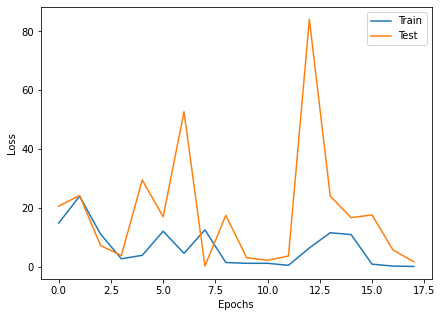

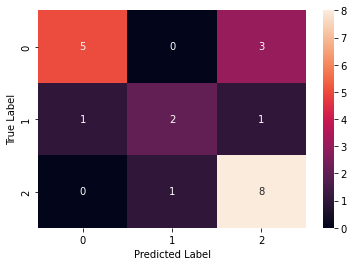

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:22.576192915439606, Test Loss: 42.92252731323242
Epoch 2-- Train Loss:15.71370538075765, Test Loss: 23.08866310119629
Epoch 3-- Train Loss:24.237290223439533, Test Loss: 16.89044761657715
Epoch 4-- Train Loss:13.832703431447348, Test Loss: 24.427066802978516
Epoch 5-- Train Loss:5.738704641660054, Test Loss: 14.695231437683105
Epoch 6-- Train Loss:2.7879174252351127, Test Loss: 4.6819634437561035
Epoch 7-- Train Loss:1.568098021428644, Test Loss: 6.257899761199951
Epoch 8-- Train Loss:0.31802403274923563, Test Loss: 0.5110155344009399
Epoch 9-- Train Loss:0.42483106985067326, Test Loss: 1.2975348234176636
Epoch 10-- Train Loss:2.193865768611431, Test Loss: 37.38546371459961
Epoch 11-- Train Loss:14.251225739717484, Test Loss: 0.22693148255348206
Epoch 12-- Train Loss:0.5239329139391581, Test Loss: 4.03952169418335
Epoch 13-- Train Loss:0.49246234943469364, Test Loss: 8.113544464111328
Epoch 14-- Train Loss:0.

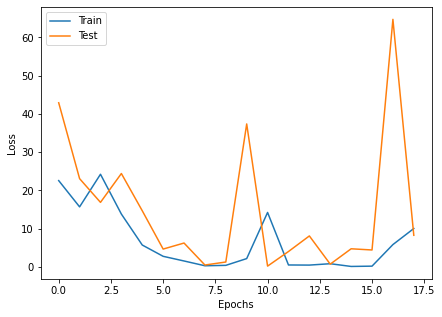

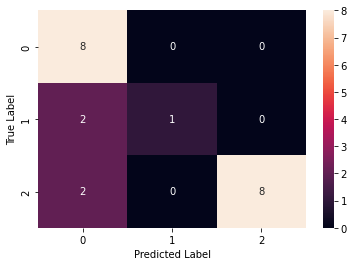

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:23.527909954388935, Test Loss: 70.15656280517578
Epoch 2-- Train Loss:20.57497163613637, Test Loss: 29.946002960205078
Epoch 3-- Train Loss:11.619932174682617, Test Loss: 1.2027069330215454
Epoch 4-- Train Loss:11.499897142251333, Test Loss: 34.22471618652344
Epoch 5-- Train Loss:6.815811527272065, Test Loss: 6.2824907302856445
Epoch 6-- Train Loss:2.2796107303972044, Test Loss: 1.1815348863601685
Epoch 7-- Train Loss:2.544737145411394, Test Loss: 10.443262100219727
Epoch 8-- Train Loss:1.1634993313540083, Test Loss: 4.218282222747803
Epoch 9-- Train Loss:0.9916671266158422, Test Loss: 14.259482383728027
Epoch 10-- Train Loss:2.309330117267867, Test Loss: 0.25594496726989746
Epoch 11-- Train Loss:1.6971495943143964, Test Loss: 39.59164047241211
Epoch 12-- Train Loss:5.590722649523134, Test Loss: 3.5649967193603516
Epoch 13-- Train Loss:0.4833354279398918, Test Loss: 20.39670753479004
Epoch 14-- Train Loss:1.4

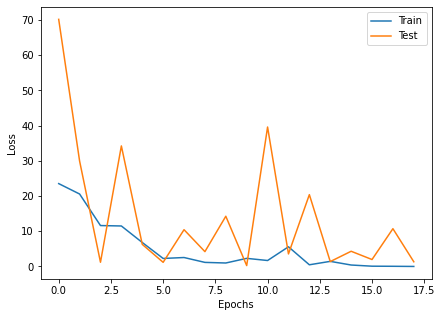

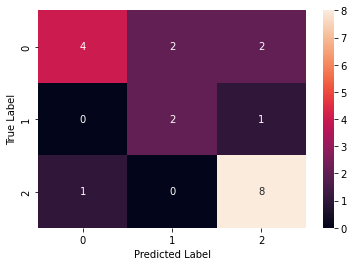

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:17.995556076367695, Test Loss: 33.69646072387695
Epoch 2-- Train Loss:26.840409358342487, Test Loss: 71.082763671875
Epoch 3-- Train Loss:12.50273863474528, Test Loss: 30.458890914916992
Epoch 4-- Train Loss:15.519630710283915, Test Loss: 32.35808181762695
Epoch 5-- Train Loss:18.913035710652668, Test Loss: 14.2379150390625
Epoch 6-- Train Loss:9.39051990287991, Test Loss: 3.473371744155884
Epoch 7-- Train Loss:2.6546814780061445, Test Loss: 5.020379543304443
Epoch 8-- Train Loss:3.499921315393294, Test Loss: 3.587583541870117
Epoch 9-- Train Loss:1.1057101152837276, Test Loss: 4.395010471343994
Epoch 10-- Train Loss:0.7531687002859447, Test Loss: 3.1509900093078613
Epoch 11-- Train Loss:0.36747296285951353, Test Loss: 1.6179288625717163
Epoch 12-- Train Loss:0.24813174842468774, Test Loss: 0.4279630482196808
Epoch 13-- Train Loss:0.21032395364682088, Test Loss: 0.0006503741024062037
Epoch 14-- Train Loss:0.0

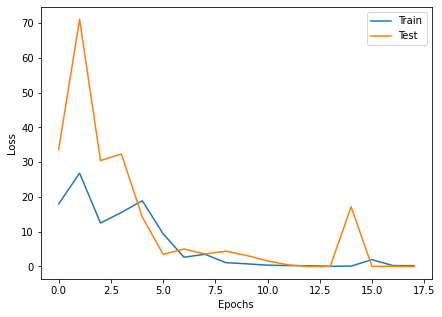

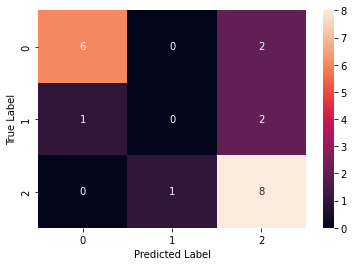

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:15.131161669890085, Test Loss: 0.0
Epoch 2-- Train Loss:15.995742221097336, Test Loss: 15.335518836975098
Epoch 3-- Train Loss:7.769476100802422, Test Loss: 11.49760627746582
Epoch 4-- Train Loss:5.7584832310676575, Test Loss: 25.225862503051758
Epoch 5-- Train Loss:3.6691076954205832, Test Loss: 23.42190933227539
Epoch 6-- Train Loss:6.450722733267715, Test Loss: 3.2758939266204834
Epoch 7-- Train Loss:1.4478254394475887, Test Loss: 13.596173286437988
Epoch 8-- Train Loss:0.8581065436204275, Test Loss: 24.84503936767578
Epoch 9-- Train Loss:0.11911176015322174, Test Loss: 0.021298419684171677
Epoch 10-- Train Loss:0.0957187623619878, Test Loss: 6.868587970733643
Epoch 11-- Train Loss:0.14863650247768115, Test Loss: 9.10596752166748
Epoch 12-- Train Loss:0.07110110257250568, Test Loss: 27.416900634765625
Epoch 13-- Train Loss:0.04488876857794762, Test Loss: 9.00124740600586
Epoch 14-- Train Loss:0.00665216624

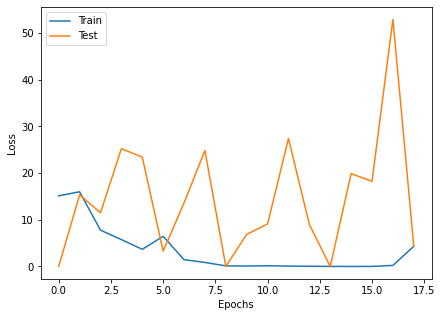

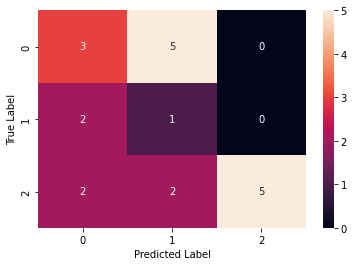

Starting testing
Training Complete
{'0': {'f1-score': '0.671±0.113',
       'precision': '0.751±0.216',
       'recall': '0.65±0.146',
       'support': 8},
 '1': {'f1-score': '0.401±0.129',
       'precision': '0.529±0.273',
       'recall': '0.383±0.145',
       'support': 4},
 '2': {'f1-score': '0.761±0.033',
       'precision': '0.805±0.159',
       'recall': '0.787±0.176',
       'support': 9},
 'accuracy': '0.667±0.097',
 'macro avg': {'f1-score': '0.611±0.085',
               'precision': '0.695±0.117',
               'recall': '0.607±0.084',
               'support': 21},
 'weighted avg': {'f1-score': '0.669±0.076',
                  'precision': '0.743±0.075',
                  'recall': '0.667±0.097',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0001, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:5.434096500233171, Test Loss: 2.3706343173980713
Epoch 2-- Train Loss:2.0836130284393826, Test Loss: 1.311301275563892e-06
Epoch 3-- T

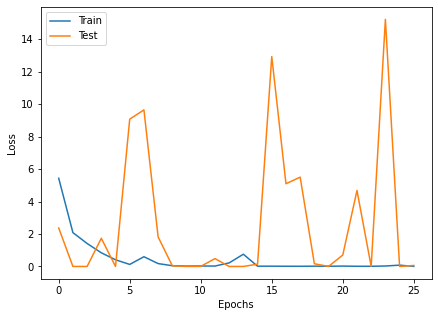

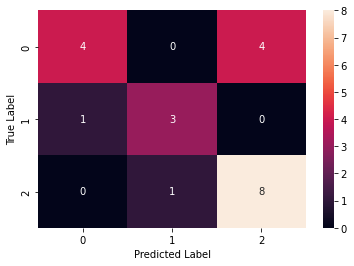

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.565731181630066, Test Loss: 0.0015906550688669086
Epoch 2-- Train Loss:3.3382297330314206, Test Loss: 0.0075643532909452915
Epoch 3-- Train Loss:1.197145220083517, Test Loss: 5.831211090087891
Epoch 4-- Train Loss:0.7058068399450609, Test Loss: 0.00400099391117692
Epoch 5-- Train Loss:0.15741300726776467, Test Loss: 0.00031585473334416747
Epoch 6-- Train Loss:0.3246451542869354, Test Loss: 7.748303323751315e-05
Epoch 7-- Train Loss:0.25374519586746047, Test Loss: 0.04877592623233795
Epoch 8-- Train Loss:0.09660421868691282, Test Loss: 0.0026291587855666876
Epoch 9-- Train Loss:0.04449514368094415, Test Loss: 0.09553147107362747
Epoch 10-- Train Loss:0.01652241304483531, Test Loss: 0.0007108307327143848
Epoch 11-- Train Loss:0.029123964833464317, Test Loss: 0.12602591514587402
Epoch 12-- Train Loss:0.02494369542996754, Test Loss: 0.0012738931691274047
Epoch 13-- Train Loss:0.016402278849065106, Test Loss: 0.

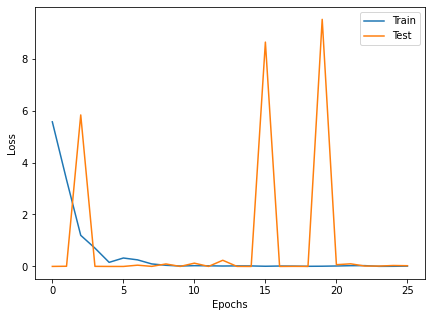

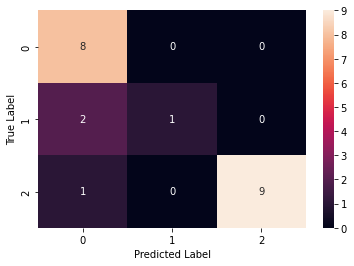

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.940126311211078, Test Loss: 17.62938690185547
Epoch 2-- Train Loss:3.0320258961430575, Test Loss: 2.523991584777832
Epoch 3-- Train Loss:0.859642367178042, Test Loss: 1.5480892658233643
Epoch 4-- Train Loss:1.3449126002725236, Test Loss: 1.7535548210144043
Epoch 5-- Train Loss:0.8061715047224425, Test Loss: 0.00021962517348583788
Epoch 6-- Train Loss:0.35555511791469707, Test Loss: 1.1138737201690674
Epoch 7-- Train Loss:0.4533610153275298, Test Loss: 0.2783510088920593
Epoch 8-- Train Loss:0.024329992541814654, Test Loss: 1.5503103733062744
Epoch 9-- Train Loss:0.04376048561902107, Test Loss: 0.1999194175004959
Epoch 10-- Train Loss:0.04916966374202318, Test Loss: 1.463464617729187
Epoch 11-- Train Loss:0.037868378868941885, Test Loss: 0.004213558044284582
Epoch 12-- Train Loss:0.03436747489052193, Test Loss: 0.0007061108481138945
Epoch 13-- Train Loss:0.026922091381579992, Test Loss: 0.2704322040081024
Ep

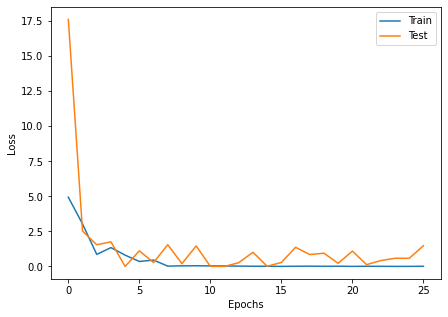

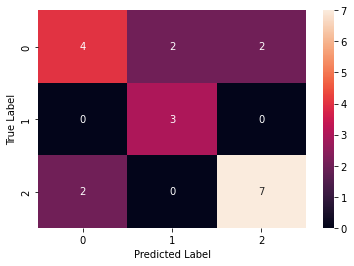

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.880289125434328, Test Loss: 9.766251564025879
Epoch 2-- Train Loss:1.700307182346781, Test Loss: 0.04680273309350014
Epoch 3-- Train Loss:1.2249268902731794, Test Loss: 2.140839099884033
Epoch 4-- Train Loss:1.4931093826889992, Test Loss: 1.3906644582748413
Epoch 5-- Train Loss:0.9460143559762011, Test Loss: 2.5886123180389404
Epoch 6-- Train Loss:0.2954378156545794, Test Loss: 0.663447916507721
Epoch 7-- Train Loss:0.21108703439330428, Test Loss: 0.1103866696357727
Epoch 8-- Train Loss:0.23752465235338605, Test Loss: 0.024443967267870903
Epoch 9-- Train Loss:0.03645667736704387, Test Loss: 0.21506433188915253
Epoch 10-- Train Loss:0.019386006029630413, Test Loss: 0.03461645543575287
Epoch 11-- Train Loss:0.027659081249112205, Test Loss: 0.04417983442544937
Epoch 12-- Train Loss:0.018373001967445037, Test Loss: 0.7053921222686768
Epoch 13-- Train Loss:0.011322037657789354, Test Loss: 0.08261307328939438
Epo

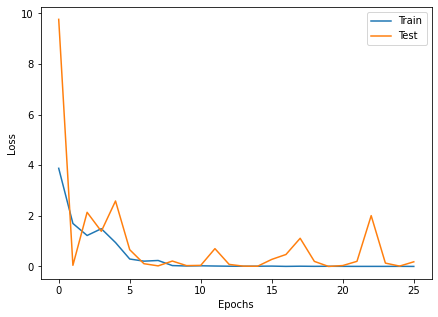

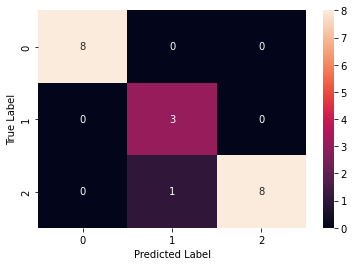

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.2499080016121815, Test Loss: 2.1373393535614014
Epoch 2-- Train Loss:2.0358290442354265, Test Loss: 5.694689750671387
Epoch 3-- Train Loss:1.5521854752940791, Test Loss: 3.9943454265594482
Epoch 4-- Train Loss:0.3278725197638518, Test Loss: 3.0468244552612305
Epoch 5-- Train Loss:0.3756722134733406, Test Loss: 2.00480580329895
Epoch 6-- Train Loss:0.3237206318091402, Test Loss: 1.3495959043502808
Epoch 7-- Train Loss:0.06625886582506132, Test Loss: 0.3869105577468872
Epoch 8-- Train Loss:0.23265636064622544, Test Loss: 0.46974220871925354
Epoch 9-- Train Loss:0.02442192534259188, Test Loss: 0.3676738142967224
Epoch 10-- Train Loss:0.029299851890148904, Test Loss: 2.693638801574707
Epoch 11-- Train Loss:0.036788254775317566, Test Loss: 1.218961238861084
Epoch 12-- Train Loss:0.025287808557983397, Test Loss: 4.395337104797363
Epoch 13-- Train Loss:0.016603595367909986, Test Loss: 0.00661975285038352
Epoch 14-

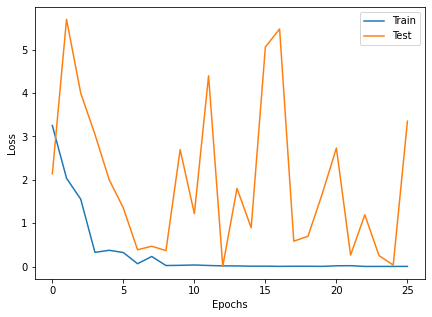

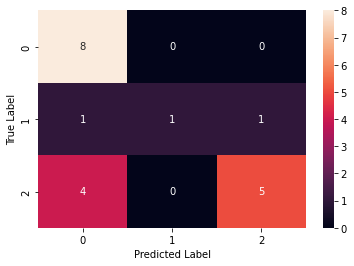

Starting testing
Training Complete
{'0': {'f1-score': '0.73±0.145',
       'precision': '0.734±0.16',
       'recall': '0.775±0.229',
       'support': 8},
 '1': {'f1-score': '0.614±0.337',
       'precision': '0.7±0.367',
       'recall': '0.617±0.393',
       'support': 4},
 '2': {'f1-score': '0.798±0.114',
       'precision': '0.816±0.124',
       'recall': '0.802±0.165',
       'support': 9},
 'accuracy': '0.764±0.103',
 'macro avg': {'f1-score': '0.714±0.141',
               'precision': '0.75±0.165',
               'recall': '0.731±0.128',
               'support': 21},
 'weighted avg': {'f1-score': '0.745±0.117',
                  'precision': '0.769±0.127',
                  'recall': '0.764±0.103',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0007000000000000001, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:22.81275433843786, Test Loss: 14.851936340332031
Epoch 2-- Train Loss:11.161917729811234, Test Loss: 13.595778465270996
Epo

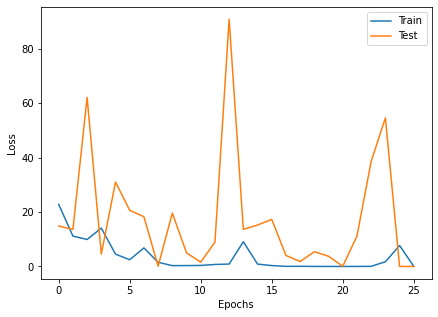

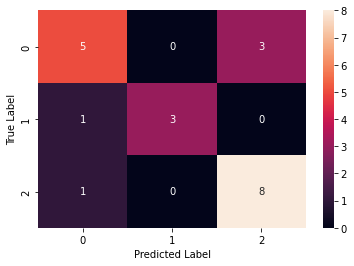

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:19.310629801316693, Test Loss: 1.6219122409820557
Epoch 2-- Train Loss:13.173426368358461, Test Loss: 24.02875518798828
Epoch 3-- Train Loss:11.826947588367727, Test Loss: 8.863362312316895
Epoch 4-- Train Loss:5.284485654397444, Test Loss: 6.787484645843506
Epoch 5-- Train Loss:4.052818055518649, Test Loss: 11.156764030456543
Epoch 6-- Train Loss:2.403472556901926, Test Loss: 0.6564351320266724
Epoch 7-- Train Loss:1.2035850281645666, Test Loss: 12.718863487243652
Epoch 8-- Train Loss:0.3990386274689089, Test Loss: 0.4142172336578369
Epoch 9-- Train Loss:0.3259879518848482, Test Loss: 16.81661605834961
Epoch 10-- Train Loss:0.3723427221085461, Test Loss: 11.149901390075684
Epoch 11-- Train Loss:2.00676780364963, Test Loss: 0.003120279172435403
Epoch 12-- Train Loss:1.0476916413571111, Test Loss: 0.5966852903366089
Epoch 13-- Train Loss:0.031010701733884295, Test Loss: 14.737385749816895
Epoch 14-- Train Loss

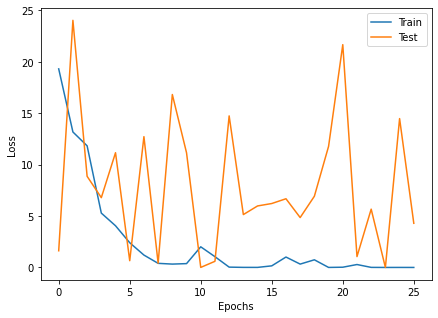

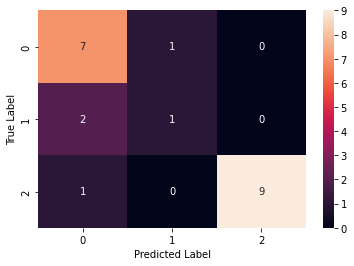

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:22.771355162967335, Test Loss: 25.13228988647461
Epoch 2-- Train Loss:22.63544463478452, Test Loss: 8.167078971862793
Epoch 3-- Train Loss:3.157989222524603, Test Loss: 5.269038200378418
Epoch 4-- Train Loss:6.068696749481288, Test Loss: 11.544976234436035
Epoch 5-- Train Loss:7.595675327561119, Test Loss: 26.03386688232422
Epoch 6-- Train Loss:7.3563387243279355, Test Loss: 3.7869150638580322
Epoch 7-- Train Loss:1.8557506762616531, Test Loss: 0.38354262709617615
Epoch 8-- Train Loss:0.7941468290512096, Test Loss: 21.404090881347656
Epoch 9-- Train Loss:1.730744562684177, Test Loss: 0.011679603718221188
Epoch 10-- Train Loss:0.10799709903573416, Test Loss: 3.6730148792266846
Epoch 11-- Train Loss:0.6922329174670714, Test Loss: 2.533575207053218e-05
Epoch 12-- Train Loss:0.7379905422767944, Test Loss: 0.0
Epoch 13-- Train Loss:0.01560132085447014, Test Loss: 3.900759696960449
Epoch 14-- Train Loss:0.311770921

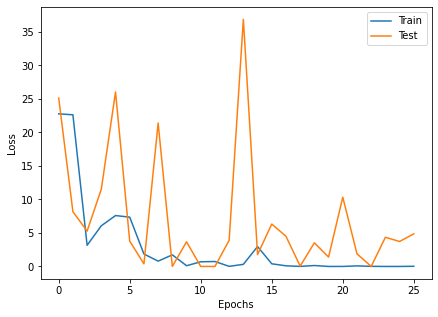

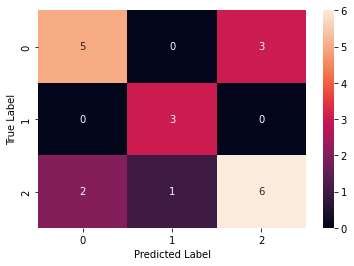

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:14.198468381708318, Test Loss: 16.564294815063477
Epoch 2-- Train Loss:8.711349178665676, Test Loss: 16.15514373779297
Epoch 3-- Train Loss:13.197261875325983, Test Loss: 6.387543678283691
Epoch 4-- Train Loss:10.984893514244256, Test Loss: 18.70136260986328
Epoch 5-- Train Loss:11.442410268566825, Test Loss: 31.13215446472168
Epoch 6-- Train Loss:5.2093593862770255, Test Loss: 11.387978553771973
Epoch 7-- Train Loss:1.0057751570514022, Test Loss: 6.839578628540039
Epoch 8-- Train Loss:2.3336396193353206, Test Loss: 26.704376220703125
Epoch 9-- Train Loss:1.6115474142302033, Test Loss: 2.5755743990885094e-06
Epoch 10-- Train Loss:0.2266093096891795, Test Loss: 0.005449254065752029
Epoch 11-- Train Loss:0.19961281081351656, Test Loss: 7.4081349339394365e-06
Epoch 12-- Train Loss:0.13225633562443628, Test Loss: 6.3784637451171875
Epoch 13-- Train Loss:0.2438439203592802, Test Loss: 19.535335540771484
Epoch 14--

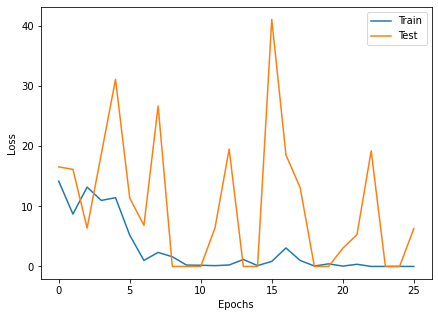

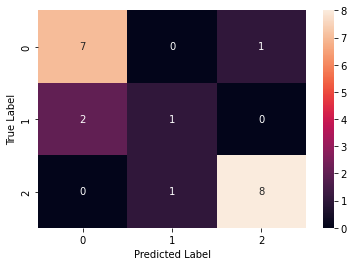

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:23.214471751993354, Test Loss: 13.105443954467773
Epoch 2-- Train Loss:9.526900537989356, Test Loss: 51.6890983581543
Epoch 3-- Train Loss:10.091504833915018, Test Loss: 19.268823623657227
Epoch 4-- Train Loss:3.036816796118563, Test Loss: 73.6788330078125
Epoch 5-- Train Loss:7.560777237794983, Test Loss: 13.079243659973145
Epoch 6-- Train Loss:3.318051171778026, Test Loss: 4.870923042297363
Epoch 7-- Train Loss:0.7724543448057601, Test Loss: 14.740324974060059
Epoch 8-- Train Loss:1.6351664508269592, Test Loss: 1.2605160474777222
Epoch 9-- Train Loss:4.33381559361111, Test Loss: 4.692018032073975
Epoch 10-- Train Loss:0.18800543892373092, Test Loss: 16.848886489868164
Epoch 11-- Train Loss:0.30229047634741785, Test Loss: 3.128079414367676
Epoch 12-- Train Loss:0.11794287681029586, Test Loss: 29.654600143432617
Epoch 13-- Train Loss:0.024512562138109848, Test Loss: 5.5285461542098346e-08
Epoch 14-- Train Los

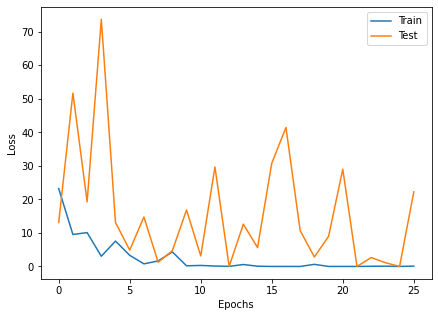

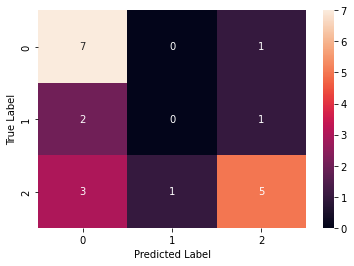

Starting testing
Training Complete
{'0': {'f1-score': '0.701±0.108',
       'precision': '0.685±0.054',
       'recall': '0.75±0.209',
       'support': 8},
 '1': {'f1-score': '0.503±0.324',
       'precision': '0.55±0.332',
       'recall': '0.483±0.351',
       'support': 4},
 '2': {'f1-score': '0.779±0.123',
       'precision': '0.798±0.146',
       'recall': '0.78±0.142',
       'support': 9},
 'accuracy': '0.725±0.069',
 'macro avg': {'f1-score': '0.661±0.093',
               'precision': '0.678±0.103',
               'recall': '0.671±0.077',
               'support': 21},
 'weighted avg': {'f1-score': '0.71±0.079',
                  'precision': '0.72±0.075',
                  'recall': '0.725±0.069',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.0007000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:17.08117268482844, Test Loss: 23.533405303955078
Epoch 2-- Train Loss:19.376420656840008, Test Loss: 13.70435905456543
Epo

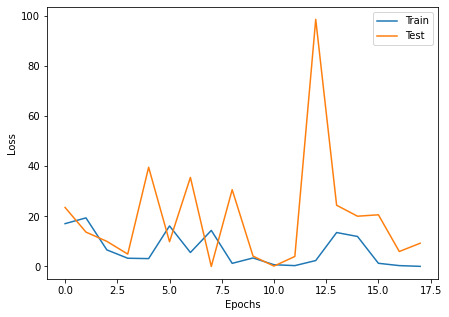

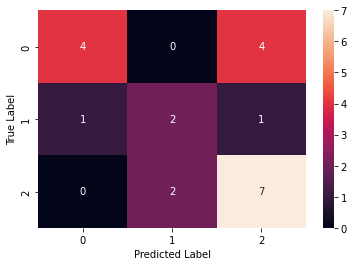

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:25.94160681962967, Test Loss: 48.68276596069336
Epoch 2-- Train Loss:18.23030153910319, Test Loss: 25.216947555541992
Epoch 3-- Train Loss:21.55200469493866, Test Loss: 21.893407821655273
Epoch 4-- Train Loss:18.535629908243816, Test Loss: 33.729209899902344
Epoch 5-- Train Loss:6.437748114267985, Test Loss: 17.46828842163086
Epoch 6-- Train Loss:2.7430567940076194, Test Loss: 7.877059459686279
Epoch 7-- Train Loss:2.440691277384758, Test Loss: 10.665400505065918
Epoch 8-- Train Loss:2.2104099839925766, Test Loss: 0.03930874168872833
Epoch 9-- Train Loss:0.2769340851000379, Test Loss: 2.8299384117126465
Epoch 10-- Train Loss:2.0286681552339965, Test Loss: 41.44314193725586
Epoch 11-- Train Loss:14.84067408243815, Test Loss: 0.005765122827142477
Epoch 12-- Train Loss:0.5932459160685539, Test Loss: 4.920825481414795
Epoch 13-- Train Loss:0.3603244076136889, Test Loss: 7.789449691772461
Epoch 14-- Train Loss:0.5

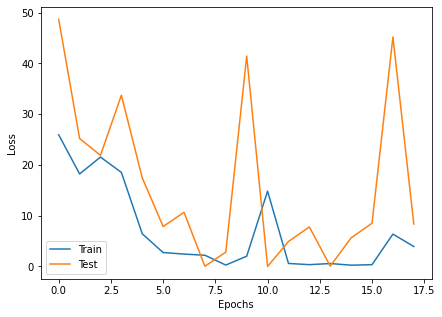

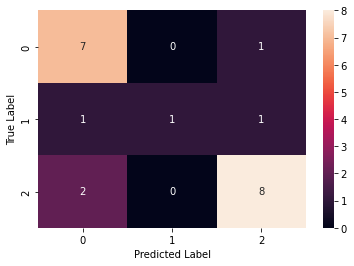

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:26.888345917065937, Test Loss: 78.03092193603516
Epoch 2-- Train Loss:22.956286549568176, Test Loss: 34.45304489135742
Epoch 3-- Train Loss:13.992546558380127, Test Loss: 5.147427082061768
Epoch 4-- Train Loss:16.101831912994385, Test Loss: 35.08517837524414
Epoch 5-- Train Loss:12.598899702231089, Test Loss: 23.22519874572754
Epoch 6-- Train Loss:8.590551495552063, Test Loss: 26.40656852722168
Epoch 7-- Train Loss:10.86738563157894, Test Loss: 16.531326293945312
Epoch 8-- Train Loss:4.376152687159522, Test Loss: 4.28563117980957
Epoch 9-- Train Loss:0.8562851262589296, Test Loss: 9.228754997253418
Epoch 10-- Train Loss:5.305767297744751, Test Loss: 19.306726455688477
Epoch 11-- Train Loss:2.6659273778398833, Test Loss: 36.25355529785156
Epoch 12-- Train Loss:4.835556425134655, Test Loss: 1.9473230838775635
Epoch 13-- Train Loss:0.2617940669207428, Test Loss: 3.786576986312866
Epoch 14-- Train Loss:0.45263441

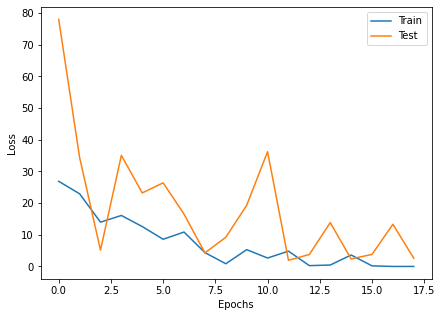

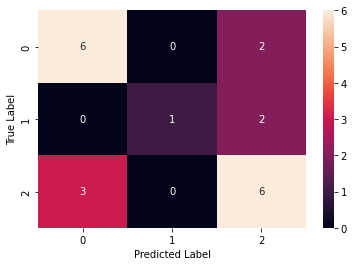

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:20.58783503373464, Test Loss: 39.224605560302734
Epoch 2-- Train Loss:30.03880039850871, Test Loss: 86.39058685302734
Epoch 3-- Train Loss:17.58573325475057, Test Loss: 33.52543640136719
Epoch 4-- Train Loss:14.126523534456888, Test Loss: 36.182743072509766
Epoch 5-- Train Loss:25.932143370310467, Test Loss: 15.065438270568848
Epoch 6-- Train Loss:9.535974462827047, Test Loss: 4.500993728637695
Epoch 7-- Train Loss:1.6636032462120056, Test Loss: 1.904711365699768
Epoch 8-- Train Loss:3.423779025518646, Test Loss: 3.6225123405456543
Epoch 9-- Train Loss:1.3070030250310083, Test Loss: 2.3507566452026367
Epoch 10-- Train Loss:0.7698474352558454, Test Loss: 0.7654411196708679
Epoch 11-- Train Loss:0.6175520902930126, Test Loss: 1.1678569316864014
Epoch 12-- Train Loss:0.5817482411606155, Test Loss: 24.064149856567383
Epoch 13-- Train Loss:2.349023523286936, Test Loss: 32.397727966308594
Epoch 14-- Train Loss:7.27

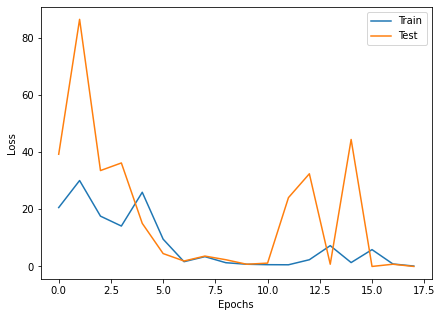

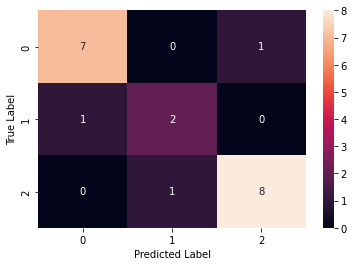

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:17.568267186482746, Test Loss: 0.0
Epoch 2-- Train Loss:14.272380113601685, Test Loss: 27.14473533630371
Epoch 3-- Train Loss:9.69626717052112, Test Loss: 4.842234134674072
Epoch 4-- Train Loss:3.351365089416504, Test Loss: 65.75961303710938
Epoch 5-- Train Loss:18.73086444536845, Test Loss: 25.887540817260742
Epoch 6-- Train Loss:6.715407793575953, Test Loss: 0.11151491105556488
Epoch 7-- Train Loss:1.779951345675272, Test Loss: 16.66236114501953
Epoch 8-- Train Loss:0.6438094675540924, Test Loss: 36.391998291015625
Epoch 9-- Train Loss:0.3277437225721466, Test Loss: 0.010938315652310848
Epoch 10-- Train Loss:0.16921274608466774, Test Loss: 10.593913078308105
Epoch 11-- Train Loss:0.08061087884319325, Test Loss: 21.288408279418945
Epoch 12-- Train Loss:0.5356397857928338, Test Loss: 39.70759963989258
Epoch 13-- Train Loss:0.14284992446331066, Test Loss: 8.837084770202637
Epoch 14-- Train Loss:0.0076712758436

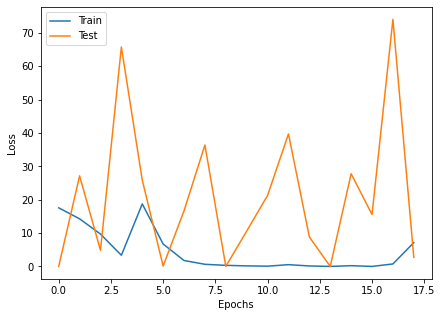

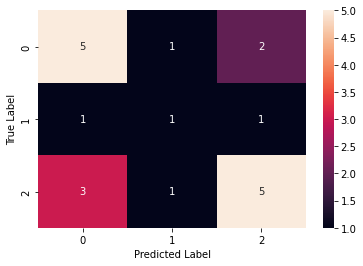

Starting testing
Training Complete
{'0': {'f1-score': '0.614±0.181',
       'precision': '0.612±0.144',
       'recall': '0.625±0.224',
       'support': 8},
 '1': {'f1-score': '0.313±0.218',
       'precision': '0.323±0.234',
       'recall': '0.317±0.213',
       'support': 4},
 '2': {'f1-score': '0.731±0.119',
       'precision': '0.733±0.166',
       'recall': '0.74±0.085',
       'support': 9},
 'accuracy': '0.628±0.148',
 'macro avg': {'f1-score': '0.553±0.168',
               'precision': '0.556±0.175',
               'recall': '0.561±0.16',
               'support': 21},
 'weighted avg': {'f1-score': '0.62±0.156',
                  'precision': '0.622±0.164',
                  'recall': '0.628±0.148',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.0008, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:27.370760321617126, Test Loss: 32.71680450439453
Epoch 2-- Train Loss:11.915194294669412, Test Loss: 7.696902275085449
Epoch 3-- Train L

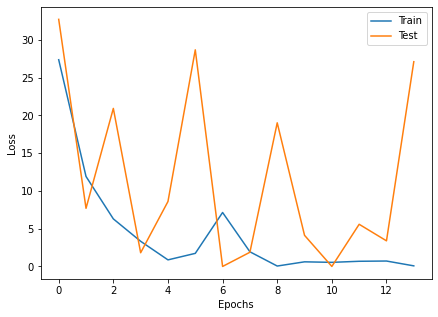

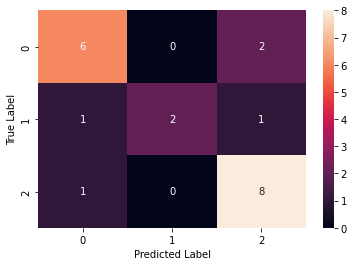

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:22.51239853555506, Test Loss: 26.804832458496094
Epoch 2-- Train Loss:14.849236141551625, Test Loss: 107.55430603027344
Epoch 3-- Train Loss:18.165345647118308, Test Loss: 5.898932456970215
Epoch 4-- Train Loss:2.6665726862847805, Test Loss: 25.3705997467041
Epoch 5-- Train Loss:4.948985197327354, Test Loss: 36.57582473754883
Epoch 6-- Train Loss:9.234738863327287, Test Loss: 13.172436714172363
Epoch 7-- Train Loss:2.2683120323723744, Test Loss: 7.089029312133789
Epoch 8-- Train Loss:0.44572494316492917, Test Loss: 1.1694719791412354
Epoch 9-- Train Loss:0.5751635575911936, Test Loss: 8.258698463439941
Epoch 10-- Train Loss:0.4729079912548183, Test Loss: 2.058015823364258
Epoch 11-- Train Loss:0.7272431864711725, Test Loss: 6.4952192306518555
Epoch 12-- Train Loss:0.6438522550557686, Test Loss: 0.0
Epoch 13-- Train Loss:0.09897930194269251, Test Loss: 2.4243216514587402
Epoch 14-- Train Loss:0.139183737221314

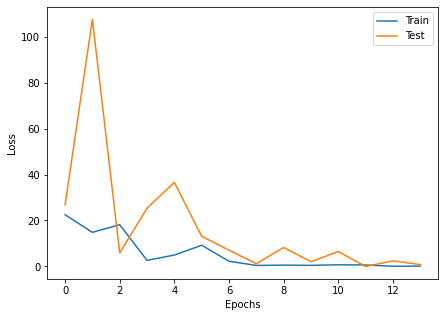

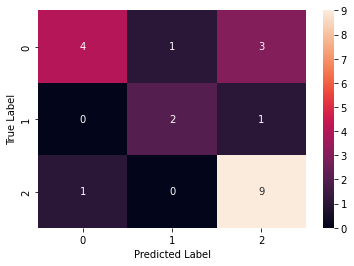

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:22.087477109648965, Test Loss: 37.80642318725586
Epoch 2-- Train Loss:16.397154549136758, Test Loss: 17.9265079498291
Epoch 3-- Train Loss:9.20434713916091, Test Loss: 9.308344841003418
Epoch 4-- Train Loss:4.354276359081268, Test Loss: 8.417181015014648
Epoch 5-- Train Loss:2.7298121318389432, Test Loss: 16.67641830444336
Epoch 6-- Train Loss:5.243318118801519, Test Loss: 6.4753031730651855
Epoch 7-- Train Loss:1.5259591860151638, Test Loss: 1.662113904953003
Epoch 8-- Train Loss:3.0766205983959067, Test Loss: 0.0
Epoch 9-- Train Loss:3.4157549316278657, Test Loss: 1.3179892301559448
Epoch 10-- Train Loss:1.0935040388974977, Test Loss: 21.0550479888916
Epoch 11-- Train Loss:3.9953855082714487, Test Loss: 7.286447048187256
Epoch 12-- Train Loss:1.3266620126503932, Test Loss: 5.194606304168701
Epoch 13-- Train Loss:0.0848198661253796, Test Loss: 0.011659127660095692
Epoch 14-- Train Loss:1.0771341475756757, Te

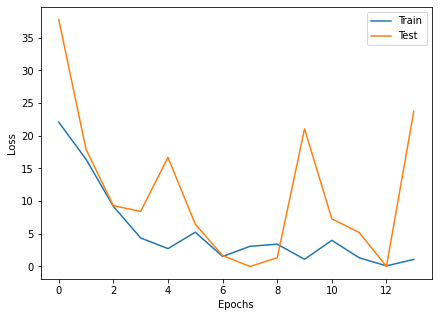

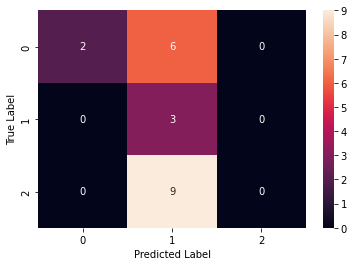

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:21.49950035051866, Test Loss: 126.0076904296875
Epoch 2-- Train Loss:26.784501162442293, Test Loss: 95.7547607421875
Epoch 3-- Train Loss:21.83338900587775, Test Loss: 2.3587536811828613
Epoch 4-- Train Loss:8.520265224982392, Test Loss: 55.22544860839844
Epoch 5-- Train Loss:10.520527021366764, Test Loss: 7.963538646697998
Epoch 6-- Train Loss:8.042849652651057, Test Loss: 10.404261589050293
Epoch 7-- Train Loss:4.378562254946536, Test Loss: 3.387173652648926
Epoch 8-- Train Loss:1.3739385749774804, Test Loss: 0.10180430114269257
Epoch 9-- Train Loss:1.5668234633400986, Test Loss: 30.380348205566406
Epoch 10-- Train Loss:1.2917883622242499, Test Loss: 12.040501594543457
Epoch 11-- Train Loss:0.45965562040560765, Test Loss: 1.690215867711231e-05
Epoch 12-- Train Loss:0.15735638669423685, Test Loss: 0.0022840688470751047
Epoch 13-- Train Loss:0.1419839967485073, Test Loss: 7.186026096343994
Epoch 14-- Train Lo

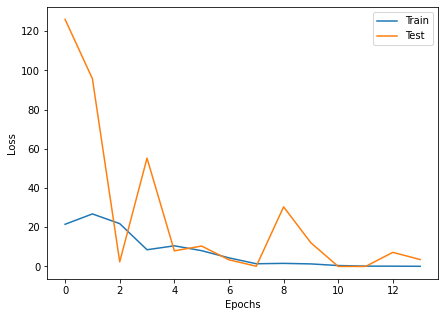

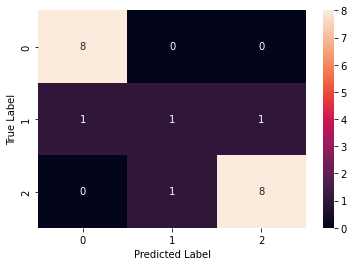

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:14.025893135504289, Test Loss: 40.83993911743164
Epoch 2-- Train Loss:15.142958272587169, Test Loss: 48.61009979248047
Epoch 3-- Train Loss:9.347690163169649, Test Loss: 19.81572723388672
Epoch 4-- Train Loss:3.7022790957072917, Test Loss: 10.917143821716309
Epoch 5-- Train Loss:4.406172166477042, Test Loss: 25.581031799316406
Epoch 6-- Train Loss:5.898808465906603, Test Loss: 1.607177972793579
Epoch 7-- Train Loss:6.060204291755165, Test Loss: 0.14888592064380646
Epoch 8-- Train Loss:2.292091027922032, Test Loss: 6.316395282745361
Epoch 9-- Train Loss:0.7319051093760539, Test Loss: 57.93919372558594
Epoch 10-- Train Loss:1.1861323554634593, Test Loss: 12.960517883300781
Epoch 11-- Train Loss:0.012035351353203034, Test Loss: 10.82888126373291
Epoch 12-- Train Loss:1.2194594788830024e-05, Test Loss: 30.792049407958984
Epoch 13-- Train Loss:4.136162640138769e-05, Test Loss: 7.7468791007995605
Epoch 14-- Train L

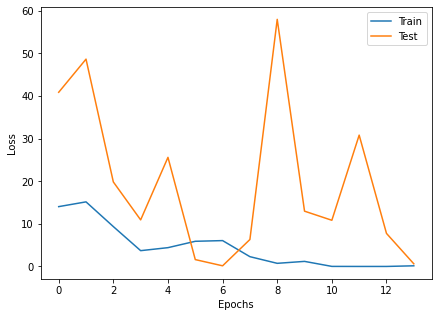

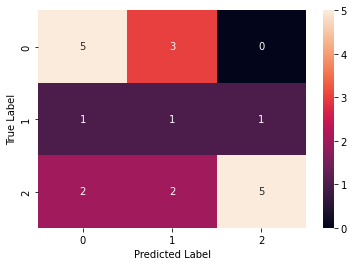

Starting testing
Training Complete
{'0': {'f1-score': '0.701±0.183',
       'precision': '0.859±0.085',
       'recall': '0.65±0.255',
       'support': 8},
 '1': {'f1-score': '0.42±0.151',
       'precision': '0.407±0.193',
       'recall': '0.567±0.249',
       'support': 4},
 '2': {'f1-score': '0.674±0.344',
       'precision': '0.668±0.342',
       'recall': '0.691±0.362',
       'support': 9},
 'accuracy': '0.655±0.214',
 'macro avg': {'f1-score': '0.599±0.194',
               'precision': '0.645±0.14',
               'recall': '0.636±0.125',
               'support': 21},
 'weighted avg': {'f1-score': '0.645±0.229',
                  'precision': '0.702±0.145',
                  'recall': '0.655±0.214',
                  'support': 21}}
{'num_epochs': 6, 'lr': 0.0009000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:21.37077711025874, Test Loss: 29.344465255737305
Epoch 2-- Train Loss:22.703934987386067, Test Loss: 21.416288375854492
E

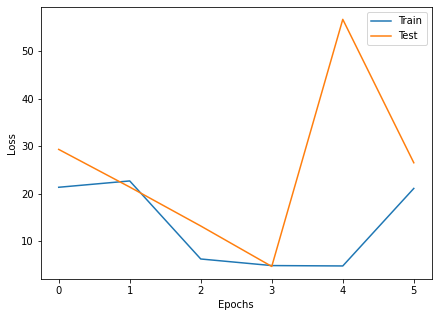

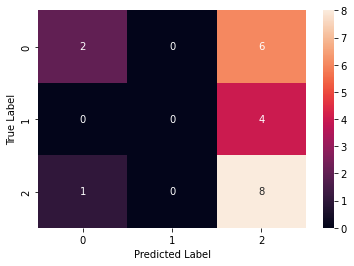

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:16.315745910008747, Test Loss: 99.426025390625
Epoch 2-- Train Loss:33.41328322887421, Test Loss: 71.6002426147461
Epoch 3-- Train Loss:23.229523022969563, Test Loss: 99.11365509033203
Epoch 4-- Train Loss:20.218687375386555, Test Loss: 8.171334266662598
Epoch 5-- Train Loss:4.5631173600753145, Test Loss: 19.59207534790039
Epoch 6-- Train Loss:4.138033489386241, Test Loss: 20.27922821044922


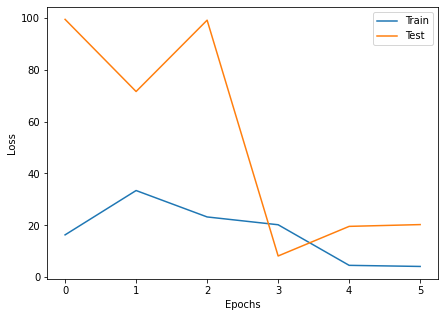

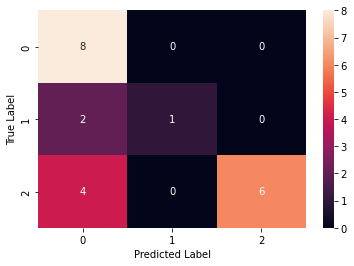

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:19.85719907247403, Test Loss: 39.29193878173828
Epoch 2-- Train Loss:17.856521288553875, Test Loss: 14.180007934570312
Epoch 3-- Train Loss:13.058704536932225, Test Loss: 2.9295601844787598
Epoch 4-- Train Loss:7.497272213300069, Test Loss: 29.060949325561523
Epoch 5-- Train Loss:10.400580525398254, Test Loss: 17.59747886657715
Epoch 6-- Train Loss:3.410335721598434, Test Loss: 4.236244201660156


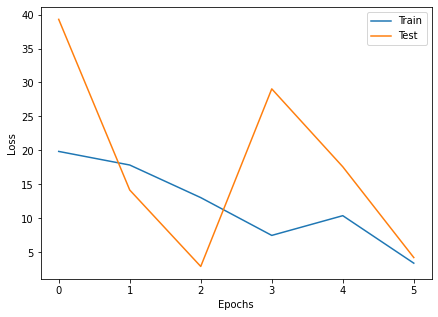

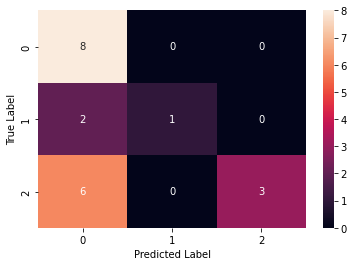

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:17.702440977096558, Test Loss: 76.44143676757812
Epoch 2-- Train Loss:25.103265285491943, Test Loss: 62.14335632324219
Epoch 3-- Train Loss:14.414668281873068, Test Loss: 0.00173378165345639
Epoch 4-- Train Loss:8.235747337341309, Test Loss: 17.887250900268555
Epoch 5-- Train Loss:11.969253540039062, Test Loss: 49.87586212158203
Epoch 6-- Train Loss:10.12745514077445, Test Loss: 6.955880165100098


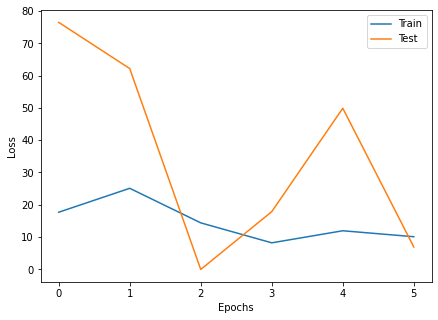

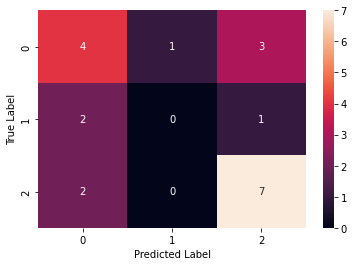

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:22.127427001794178, Test Loss: 21.227291107177734
Epoch 2-- Train Loss:16.10554790496826, Test Loss: 27.652482986450195
Epoch 3-- Train Loss:16.297329485416395, Test Loss: 18.393938064575195
Epoch 4-- Train Loss:5.965506474177043, Test Loss: 20.234251022338867
Epoch 5-- Train Loss:7.368496576944987, Test Loss: 16.247539520263672
Epoch 6-- Train Loss:2.5149483781230324, Test Loss: 6.430737018585205


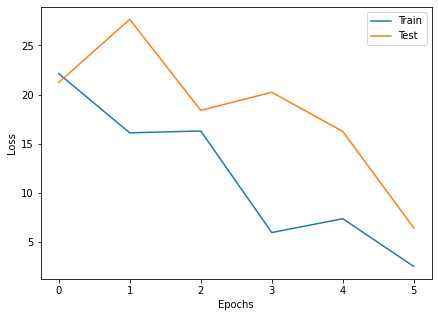

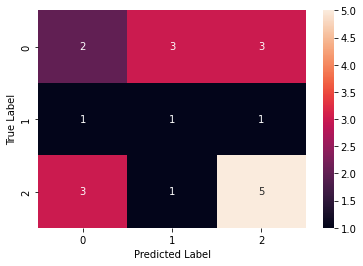

Starting testing
Training Complete
{'0': {'f1-score': '0.594±0.16',
       'precision': '0.544±0.068',
       'recall': '0.725±0.3',
       'support': 8},
 '1': {'f1-score': '0.344±0.203',
       'precision': '0.633±0.452',
       'recall': '0.267±0.133',
       'support': 4},
 '2': {'f1-score': '0.659±0.169',
       'precision': '0.836±0.194',
       'recall': '0.629±0.23',
       'support': 9},
 'accuracy': '0.608±0.123',
 'macro avg': {'f1-score': '0.532±0.143',
               'precision': '0.671±0.22',
               'recall': '0.54±0.115',
               'support': 21},
 'weighted avg': {'f1-score': '0.583±0.142',
                  'precision': '0.686±0.17',
                  'recall': '0.608±0.123',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.0002, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.399681528409322, Test Loss: 4.01616096496582
Epoch 2-- Train Loss:2.7691367864608765, Test Loss: 18.227651596069336
Epoch 3-- Train Loss:

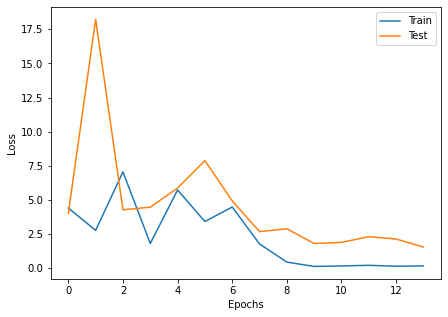

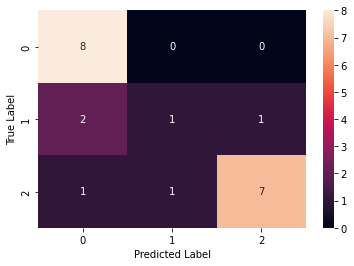

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.3155494133631387, Test Loss: 4.043296813964844
Epoch 2-- Train Loss:5.923967679341634, Test Loss: 3.9575037956237793
Epoch 3-- Train Loss:3.7478838761647544, Test Loss: 2.81997013092041
Epoch 4-- Train Loss:4.45164422194163, Test Loss: 6.701615333557129
Epoch 5-- Train Loss:5.980390310287476, Test Loss: 6.0411481857299805
Epoch 6-- Train Loss:3.2891701459884644, Test Loss: 1.2032123804092407
Epoch 7-- Train Loss:0.6190206607182821, Test Loss: 2.4030561447143555
Epoch 8-- Train Loss:1.6209492286046345, Test Loss: 3.214366912841797
Epoch 9-- Train Loss:1.0869629283746083, Test Loss: 1.48428475856781
Epoch 10-- Train Loss:0.22424795230229697, Test Loss: 1.4877986907958984
Epoch 11-- Train Loss:0.16867139687140784, Test Loss: 1.3627585172653198
Epoch 12-- Train Loss:0.09179737667242686, Test Loss: 1.0076793432235718
Epoch 13-- Train Loss:0.09501754616697629, Test Loss: 0.8773171901702881
Epoch 14-- Train Loss:0

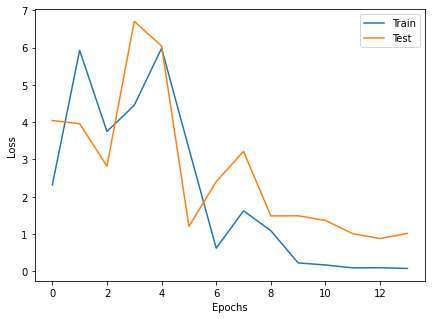

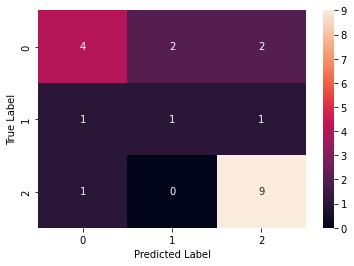

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:6.044020255406697, Test Loss: 2.175837993621826
Epoch 2-- Train Loss:2.39297616481781, Test Loss: 5.018950462341309
Epoch 3-- Train Loss:4.39246129989624, Test Loss: 10.106586456298828
Epoch 4-- Train Loss:3.2890155712763467, Test Loss: 3.779914379119873
Epoch 5-- Train Loss:3.5215245882670083, Test Loss: 5.511815071105957
Epoch 6-- Train Loss:2.9365479151407876, Test Loss: 2.47198748588562
Epoch 7-- Train Loss:1.5942762692769368, Test Loss: 2.2181432247161865
Epoch 8-- Train Loss:1.6060574054718018, Test Loss: 5.66386604309082
Epoch 9-- Train Loss:1.847012460231781, Test Loss: 1.2174174785614014
Epoch 10-- Train Loss:0.2741992101073265, Test Loss: 0.9848167896270752
Epoch 11-- Train Loss:0.14400208741426468, Test Loss: 0.9093694090843201
Epoch 12-- Train Loss:0.08034365934630235, Test Loss: 0.7966197729110718
Epoch 13-- Train Loss:0.05576181039214134, Test Loss: 0.9281231760978699
Epoch 14-- Train Loss:0.062

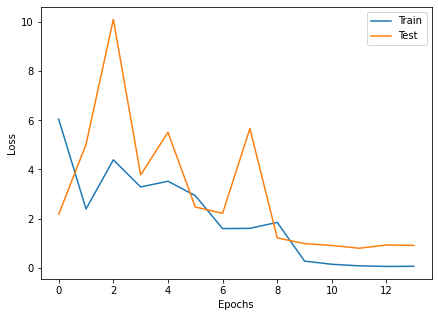

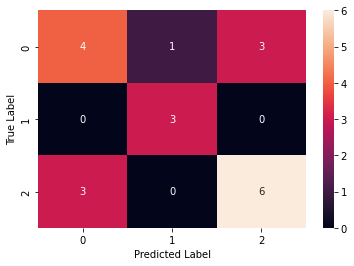

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.023623983065287, Test Loss: 6.319670677185059
Epoch 2-- Train Loss:5.3386945724487305, Test Loss: 8.019007682800293
Epoch 3-- Train Loss:4.529183983802795, Test Loss: 2.621616840362549
Epoch 4-- Train Loss:3.662787675857544, Test Loss: 3.2012245655059814
Epoch 5-- Train Loss:2.3877113858858743, Test Loss: 0.665510892868042
Epoch 6-- Train Loss:0.8771684964497884, Test Loss: 4.4119954109191895
Epoch 7-- Train Loss:2.4033839305241904, Test Loss: 5.1315460205078125
Epoch 8-- Train Loss:1.7601100603739421, Test Loss: 1.587570071220398
Epoch 9-- Train Loss:0.6205457051595052, Test Loss: 0.6857282519340515
Epoch 10-- Train Loss:0.3697345058123271, Test Loss: 1.5258421897888184
Epoch 11-- Train Loss:0.9329206446806589, Test Loss: 1.800817608833313
Epoch 12-- Train Loss:0.39228344957033795, Test Loss: 0.7885932326316833
Epoch 13-- Train Loss:0.21714123586813608, Test Loss: 0.977042019367218
Epoch 14-- Train Loss:0.

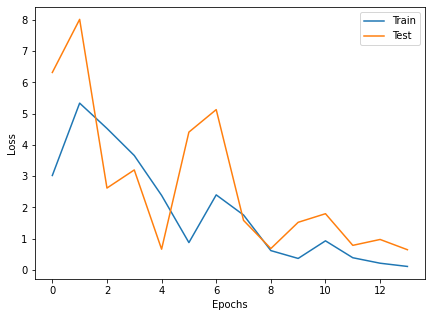

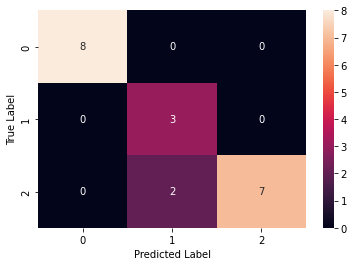

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:6.387618978818257, Test Loss: 14.382262229919434
Epoch 2-- Train Loss:7.32007098197937, Test Loss: 11.237951278686523
Epoch 3-- Train Loss:3.3500083287556968, Test Loss: 5.878403186798096
Epoch 4-- Train Loss:1.5566679040590923, Test Loss: 2.867447853088379
Epoch 5-- Train Loss:0.8578056991100311, Test Loss: 6.271010875701904
Epoch 6-- Train Loss:3.7783323923746743, Test Loss: 3.8922064304351807
Epoch 7-- Train Loss:3.0672496954600015, Test Loss: 6.41180944442749
Epoch 8-- Train Loss:0.6601718813180923, Test Loss: 3.7088708877563477
Epoch 9-- Train Loss:0.12981491163372993, Test Loss: 2.698572874069214
Epoch 10-- Train Loss:0.09686398692429066, Test Loss: 2.7042179107666016
Epoch 11-- Train Loss:0.05716824779907862, Test Loss: 2.8238861560821533
Epoch 12-- Train Loss:0.10088491812348366, Test Loss: 2.861476421356201
Epoch 13-- Train Loss:0.03895637020468712, Test Loss: 2.8362696170806885
Epoch 14-- Train Loss

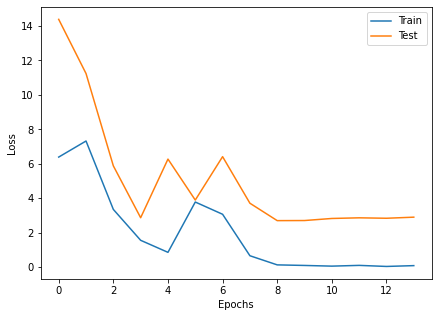

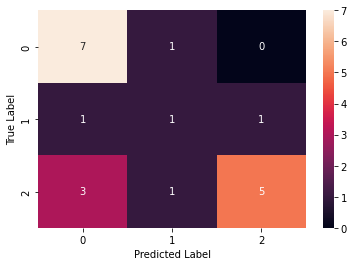

Starting testing
Training Complete
{'0': {'f1-score': '0.765±0.154',
       'precision': '0.726±0.155',
       'recall': '0.825±0.187',
       'support': 8},
 '1': {'f1-score': '0.535±0.223',
       'precision': '0.537±0.137',
       'recall': '0.583±0.342',
       'support': 4},
 '2': {'f1-score': '0.759±0.119',
       'precision': '0.832±0.108',
       'recall': '0.713±0.153',
       'support': 9},
 'accuracy': '0.735±0.104',
 'macro avg': {'f1-score': '0.686±0.109',
               'precision': '0.698±0.095',
               'recall': '0.707±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.725±0.109',
                  'precision': '0.744±0.109',
                  'recall': '0.735±0.104',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.0007000000000000001, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:15.097132404645285, Test Loss: 21.623083114624023
Epoch 2-- Train Loss:27.259419759114582, Test Loss: 9.4313497543334

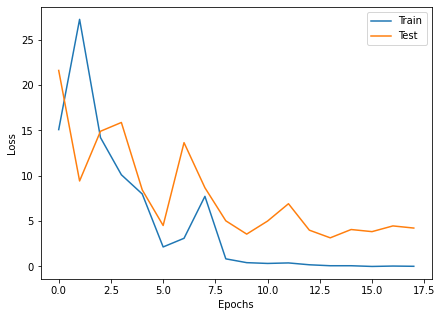

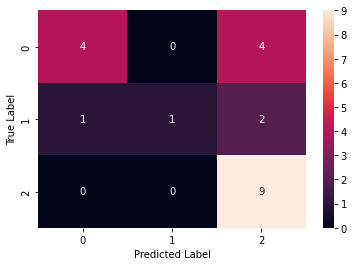

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:12.237455646197, Test Loss: 12.426193237304688
Epoch 2-- Train Loss:19.56914742787679, Test Loss: 32.671478271484375
Epoch 3-- Train Loss:17.862018426259358, Test Loss: 4.445107460021973
Epoch 4-- Train Loss:8.904840071996054, Test Loss: 18.740921020507812
Epoch 5-- Train Loss:6.1377187098066015, Test Loss: 5.767404079437256
Epoch 6-- Train Loss:7.413443962732951, Test Loss: 18.68760108947754
Epoch 7-- Train Loss:8.032029549280802, Test Loss: 5.091812610626221
Epoch 8-- Train Loss:1.479429731766383, Test Loss: 5.466792106628418
Epoch 9-- Train Loss:1.3082074125607808, Test Loss: 5.199647903442383
Epoch 10-- Train Loss:0.45805225272973377, Test Loss: 3.0966691970825195
Epoch 11-- Train Loss:0.07118930884947379, Test Loss: 3.1893537044525146
Epoch 12-- Train Loss:0.06076087926824888, Test Loss: 3.0789458751678467
Epoch 13-- Train Loss:0.09641345745573442, Test Loss: 3.270142078399658
Epoch 14-- Train Loss:0.067

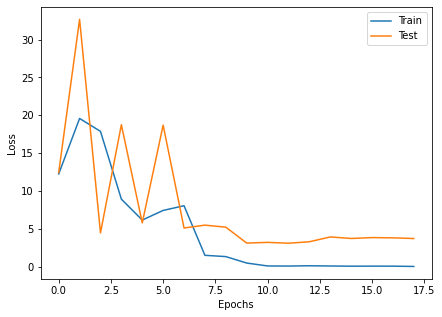

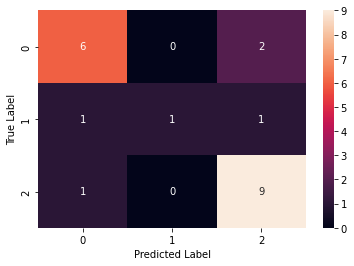

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:17.62214740117391, Test Loss: 16.02485466003418
Epoch 2-- Train Loss:27.721161206563313, Test Loss: 10.028367042541504
Epoch 3-- Train Loss:18.73430411020915, Test Loss: 13.569053649902344
Epoch 4-- Train Loss:3.7157293558120728, Test Loss: 13.729292869567871
Epoch 5-- Train Loss:5.5215427080790205, Test Loss: 7.53116512298584
Epoch 6-- Train Loss:1.760329931974411, Test Loss: 2.6151857376098633
Epoch 7-- Train Loss:1.5769200921058655, Test Loss: 3.151122570037842
Epoch 8-- Train Loss:2.480681538581848, Test Loss: 1.3580867052078247
Epoch 9-- Train Loss:0.30273295442263287, Test Loss: 4.780571460723877
Epoch 10-- Train Loss:4.63416314125061, Test Loss: 8.754263877868652
Epoch 11-- Train Loss:4.119185368220012, Test Loss: 5.306562423706055
Epoch 12-- Train Loss:2.931932032108307, Test Loss: 1.8819801807403564
Epoch 13-- Train Loss:0.24782687425613403, Test Loss: 2.5859017372131348
Epoch 14-- Train Loss:0.13390

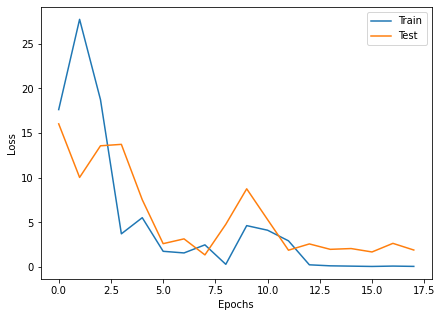

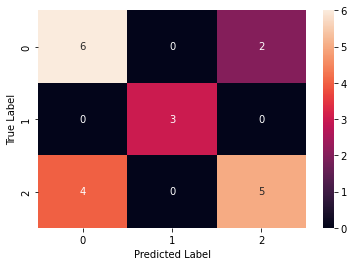

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:15.093869010607401, Test Loss: 56.828086853027344
Epoch 2-- Train Loss:25.44400469462077, Test Loss: 44.76962661743164
Epoch 3-- Train Loss:27.084795316060383, Test Loss: 42.47867965698242
Epoch 4-- Train Loss:17.288227876027424, Test Loss: 12.689784049987793
Epoch 5-- Train Loss:4.4041407108306885, Test Loss: 7.436413288116455
Epoch 6-- Train Loss:1.7507953246434529, Test Loss: 4.4232964515686035
Epoch 7-- Train Loss:0.5640606035788854, Test Loss: 2.258326292037964
Epoch 8-- Train Loss:0.5291722615559896, Test Loss: 2.9674057960510254
Epoch 9-- Train Loss:0.15552389497558275, Test Loss: 2.0017170906066895
Epoch 10-- Train Loss:0.13333220135731003, Test Loss: 2.119682788848877
Epoch 11-- Train Loss:2.5469817171494165, Test Loss: 21.30783462524414
Epoch 12-- Train Loss:12.535054842631022, Test Loss: 4.719979286193848
Epoch 13-- Train Loss:0.6211918336339295, Test Loss: 3.574536085128784
Epoch 14-- Train Loss:0

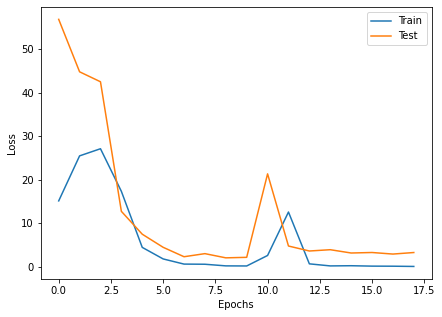

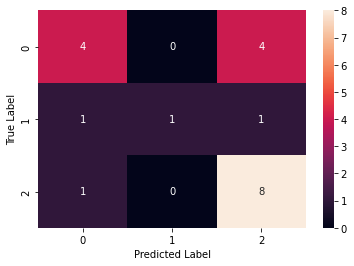

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:5.9982606172561646, Test Loss: 39.10810470581055
Epoch 2-- Train Loss:18.713172753651936, Test Loss: 13.253471374511719
Epoch 3-- Train Loss:10.618326187133789, Test Loss: 10.370238304138184
Epoch 4-- Train Loss:3.36781636873881, Test Loss: 20.376922607421875
Epoch 5-- Train Loss:18.885130564371746, Test Loss: 34.06557083129883
Epoch 6-- Train Loss:8.922913253307343, Test Loss: 7.924511432647705
Epoch 7-- Train Loss:0.7760430773099264, Test Loss: 9.008190155029297
Epoch 8-- Train Loss:0.564764271179835, Test Loss: 10.512274742126465
Epoch 9-- Train Loss:0.7253016261383891, Test Loss: 8.186540603637695
Epoch 10-- Train Loss:0.1300396754522808, Test Loss: 7.69350528717041
Epoch 11-- Train Loss:0.04216915931707869, Test Loss: 7.28368616104126
Epoch 12-- Train Loss:0.17575287818908691, Test Loss: 7.06102180480957
Epoch 13-- Train Loss:0.014939381430546442, Test Loss: 7.752157211303711
Epoch 14-- Train Loss:0.0313

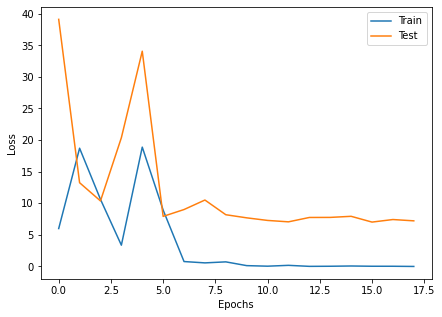

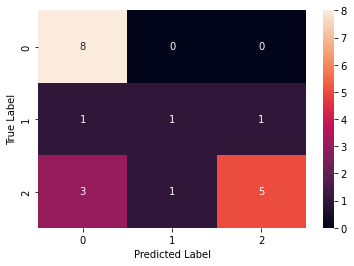

Starting testing
Training Complete
{'0': {'f1-score': '0.718±0.073',
       'precision': '0.718±0.095',
       'recall': '0.75±0.158',
       'support': 8},
 '1': {'f1-score': '0.591±0.198',
       'precision': '0.85±0.2',
       'recall': '0.517±0.281',
       'support': 4},
 '2': {'f1-score': '0.729±0.054',
       'precision': '0.744±0.086',
       'recall': '0.76±0.179',
       'support': 9},
 'accuracy': '0.716±0.045',
 'macro avg': {'f1-score': '0.679±0.076',
               'precision': '0.771±0.067',
               'recall': '0.676±0.078',
               'support': 21},
 'weighted avg': {'f1-score': '0.702±0.055',
                  'precision': '0.752±0.036',
                  'recall': '0.716±0.045',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0002, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:8.250165959021874, Test Loss: 0.0017556031234562397
Epoch 2-- Train Loss:3.312033048343091, Test Loss: 1.1920928244535389e-07
Epoch 3-- Tr

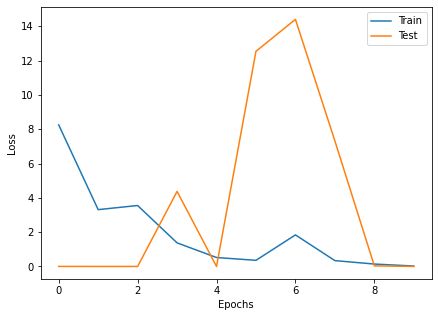

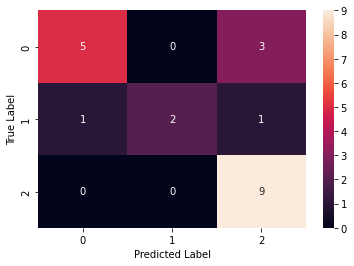

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:9.844312554314023, Test Loss: 46.57035827636719
Epoch 2-- Train Loss:3.7455379270970646, Test Loss: 0.0
Epoch 3-- Train Loss:1.3805879953769054, Test Loss: 1.1920928244535389e-07
Epoch 4-- Train Loss:0.794443562684599, Test Loss: 0.02688816376030445
Epoch 5-- Train Loss:0.9653607553861698, Test Loss: 5.6429924964904785
Epoch 6-- Train Loss:1.7427576303520407, Test Loss: 9.756468772888184
Epoch 7-- Train Loss:0.2543583657149078, Test Loss: 0.002148702275007963
Epoch 8-- Train Loss:0.15936073786853977, Test Loss: 10.762555122375488
Epoch 9-- Train Loss:0.16182790116309456, Test Loss: 0.1181052178144455
Epoch 10-- Train Loss:0.11936933754818552, Test Loss: 5.5598368644714355


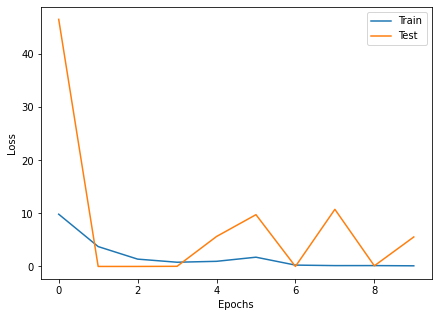

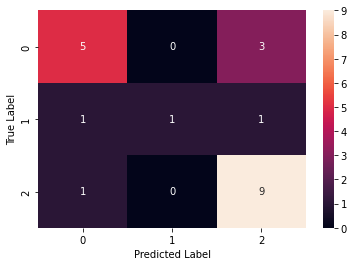

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:10.620266375087557, Test Loss: 16.72955322265625
Epoch 2-- Train Loss:6.176115771511658, Test Loss: 6.042259216308594
Epoch 3-- Train Loss:2.9770722577589344, Test Loss: 3.35455584526062
Epoch 4-- Train Loss:1.0132920041083016, Test Loss: 1.0942524671554565
Epoch 5-- Train Loss:0.9658591733286379, Test Loss: 0.35713887214660645
Epoch 6-- Train Loss:0.5888496628859208, Test Loss: 6.791024208068848
Epoch 7-- Train Loss:0.3870856743057651, Test Loss: 2.026533842086792
Epoch 8-- Train Loss:1.067525230962344, Test Loss: 10.61401081085205
Epoch 9-- Train Loss:1.3571999318727475, Test Loss: 1.358145833015442
Epoch 10-- Train Loss:0.31308640406340243, Test Loss: 10.832744598388672


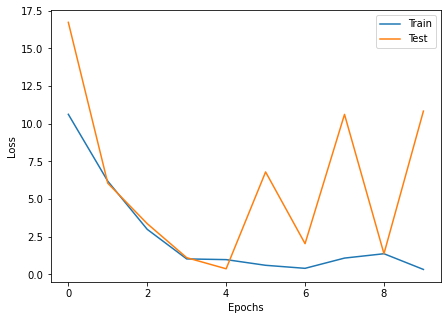

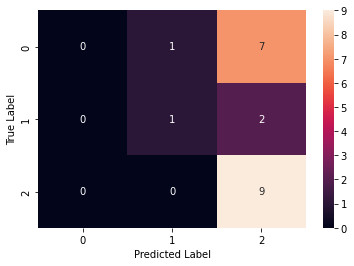

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:7.323378854995099, Test Loss: 10.525237083435059
Epoch 2-- Train Loss:4.54526332276255, Test Loss: 12.607965469360352
Epoch 3-- Train Loss:2.616939101444911, Test Loss: 10.460124015808105
Epoch 4-- Train Loss:1.908842015077209, Test Loss: 1.4411280155181885
Epoch 5-- Train Loss:1.0617996855005025, Test Loss: 26.09577751159668
Epoch 6-- Train Loss:4.622819190735927, Test Loss: 8.234493255615234
Epoch 7-- Train Loss:1.3962720929730696, Test Loss: 2.6239118576049805
Epoch 8-- Train Loss:0.16967863030123115, Test Loss: 2.6089580059051514
Epoch 9-- Train Loss:0.13126258674577448, Test Loss: 1.1155943870544434
Epoch 10-- Train Loss:0.10621988946944666, Test Loss: 0.00016874349967110902


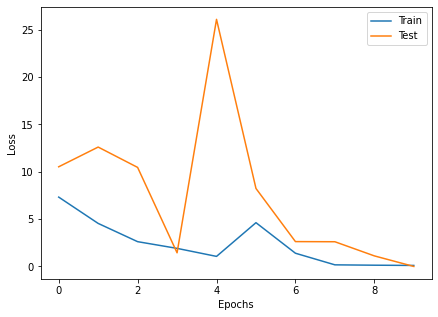

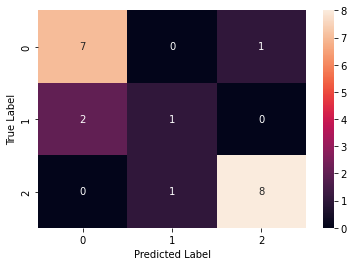

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:7.942674749397805, Test Loss: 14.098074913024902
Epoch 2-- Train Loss:2.6479655756939193, Test Loss: 7.0518341064453125
Epoch 3-- Train Loss:1.6861476791698027, Test Loss: 2.0799143314361572
Epoch 4-- Train Loss:0.8949401152744291, Test Loss: 2.935753345489502
Epoch 5-- Train Loss:2.002051531506281, Test Loss: 5.123984336853027
Epoch 6-- Train Loss:0.20740361481994168, Test Loss: 1.985959768295288
Epoch 7-- Train Loss:0.040511060996892855, Test Loss: 2.960548162460327
Epoch 8-- Train Loss:0.02957749693954847, Test Loss: 1.3334858417510986
Epoch 9-- Train Loss:0.05183565732380623, Test Loss: 3.4535863399505615
Epoch 10-- Train Loss:0.009360166027238933, Test Loss: 7.160511016845703


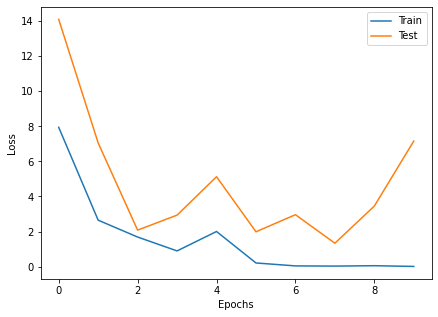

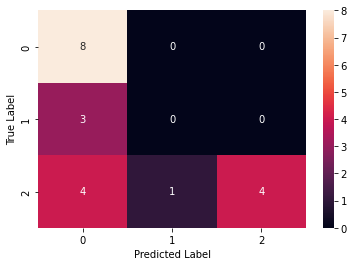

Starting testing
Training Complete
{'0': {'f1-score': '0.622±0.333',
       'precision': '0.6±0.335',
       'recall': '0.675±0.367',
       'support': 8},
 '1': {'f1-score': '0.351±0.325',
       'precision': '0.55±0.458',
       'recall': '0.317±0.367',
       'support': 4},
 '2': {'f1-score': '0.754±0.137',
       'precision': '0.738±0.178',
       'recall': '0.847±0.207',
       'support': 9},
 'accuracy': '0.695±0.167',
 'macro avg': {'f1-score': '0.576±0.246',
               'precision': '0.629±0.289',
               'recall': '0.613±0.21',
               'support': 21},
 'weighted avg': {'f1-score': '0.639±0.224',
                  'precision': '0.657±0.258',
                  'recall': '0.695±0.167',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0005, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:22.21025715824882, Test Loss: 24.447242736816406
Epoch 2-- Train Loss:8.703252960444107, Test Loss: 0.0
Epoch 3-- Train Loss:7.3196437965

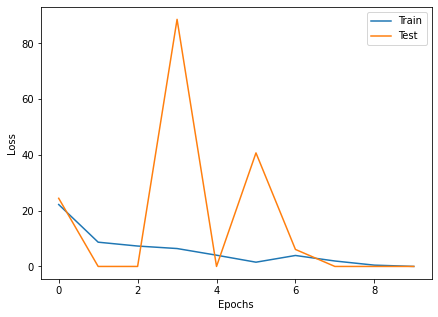

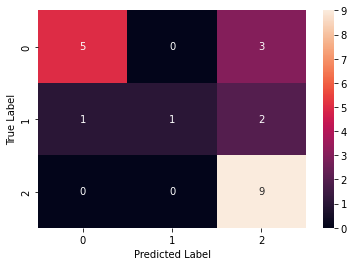

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:18.50179310072036, Test Loss: 86.12899780273438
Epoch 2-- Train Loss:9.71733204874077, Test Loss: 0.0
Epoch 3-- Train Loss:5.2163387400424615, Test Loss: 0.0
Epoch 4-- Train Loss:2.846625990405876, Test Loss: 0.0
Epoch 5-- Train Loss:2.6752638647607303, Test Loss: 0.0016094601014629006
Epoch 6-- Train Loss:4.986770296294232, Test Loss: 19.813552856445312
Epoch 7-- Train Loss:1.4261955799607984, Test Loss: 6.437280717364047e-06
Epoch 8-- Train Loss:1.4699484958472258, Test Loss: 30.217926025390625
Epoch 9-- Train Loss:0.6892224115059175, Test Loss: 0.0
Epoch 10-- Train Loss:0.21474689851600848, Test Loss: 7.027565956115723


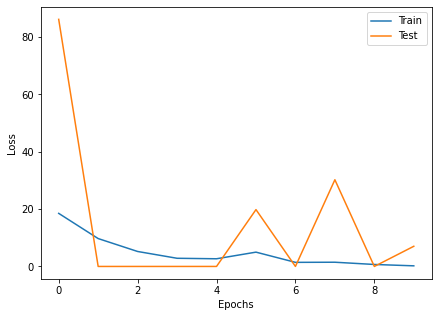

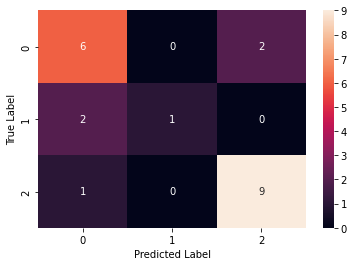

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:21.162108336176193, Test Loss: 23.72809410095215
Epoch 2-- Train Loss:15.167345137823196, Test Loss: 11.777033805847168
Epoch 3-- Train Loss:7.570309984373688, Test Loss: 4.252788066864014
Epoch 4-- Train Loss:1.6561259441386464, Test Loss: 2.6230974197387695
Epoch 5-- Train Loss:5.016696150050853, Test Loss: 5.085975170135498
Epoch 6-- Train Loss:3.8684595788441962, Test Loss: 8.5978364944458
Epoch 7-- Train Loss:2.378188478624947, Test Loss: 3.927168607711792
Epoch 8-- Train Loss:2.3760029047540048, Test Loss: 1.7223223447799683
Epoch 9-- Train Loss:0.11351224298179018, Test Loss: 0.9006800651550293
Epoch 10-- Train Loss:0.6754793893558332, Test Loss: 10.341068267822266


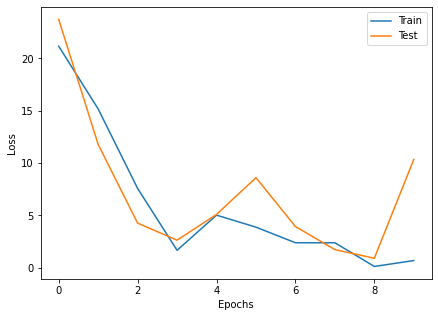

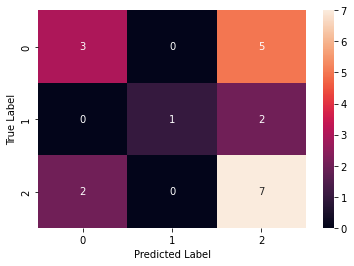

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:19.8403010054997, Test Loss: 18.683374404907227
Epoch 2-- Train Loss:12.138088346583014, Test Loss: 16.51934051513672
Epoch 3-- Train Loss:7.746610689023868, Test Loss: 15.022052764892578
Epoch 4-- Train Loss:8.375761200715951, Test Loss: 4.087178707122803
Epoch 5-- Train Loss:2.842754348029492, Test Loss: 25.118133544921875
Epoch 6-- Train Loss:3.2803154886435997, Test Loss: 23.62407112121582
Epoch 7-- Train Loss:2.4237766504210887, Test Loss: 1.1700398921966553
Epoch 8-- Train Loss:1.9469656707466627, Test Loss: 2.0907325744628906
Epoch 9-- Train Loss:1.6911919282697563, Test Loss: 2.3114583492279053
Epoch 10-- Train Loss:1.1551554029858135, Test Loss: 0.001354564563371241


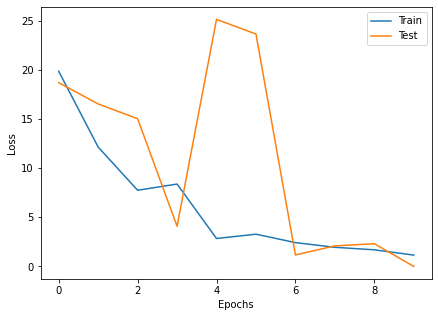

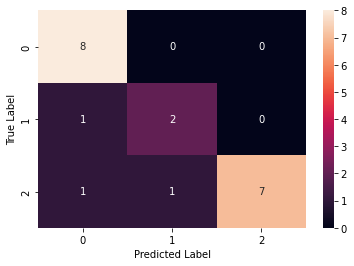

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:18.540600682837606, Test Loss: 31.393661499023438
Epoch 2-- Train Loss:5.792889508148489, Test Loss: 6.886603832244873
Epoch 3-- Train Loss:5.615210931537495, Test Loss: 45.922630310058594
Epoch 4-- Train Loss:2.890594693384255, Test Loss: 1.7506742477416992
Epoch 5-- Train Loss:6.021024298963658, Test Loss: 8.569826126098633
Epoch 6-- Train Loss:2.507200018345332, Test Loss: 6.714245870398372e-08
Epoch 7-- Train Loss:0.7814919895865164, Test Loss: 7.4315948486328125
Epoch 8-- Train Loss:0.15619910877907323, Test Loss: 2.157374620437622
Epoch 9-- Train Loss:0.3025330688044767, Test Loss: 7.195704460144043
Epoch 10-- Train Loss:0.18278579377805756, Test Loss: 25.54849624633789


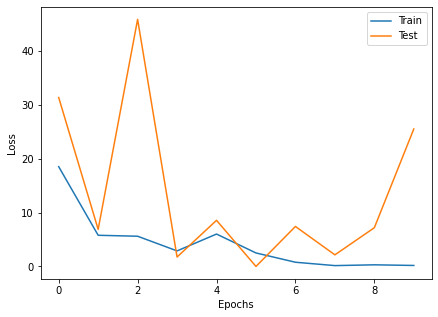

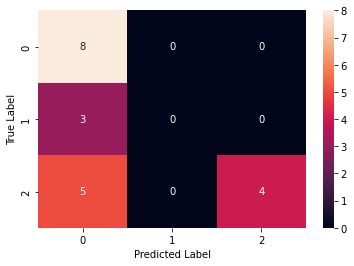

Starting testing
Training Complete
{'0': {'f1-score': '0.699±0.162',
       'precision': '0.694±0.152',
       'recall': '0.75±0.237',
       'support': 8},
 '1': {'f1-score': '0.347±0.299',
       'precision': '0.367±0.306',
       'recall': '0.333±0.298',
       'support': 4},
 '2': {'f1-score': '0.754±0.112',
       'precision': '0.791±0.177',
       'recall': '0.782±0.186',
       'support': 9},
 'accuracy': '0.696±0.111',
 'macro avg': {'f1-score': '0.6±0.14',
               'precision': '0.617±0.128',
               'recall': '0.622±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.665±0.124',
                  'precision': '0.683±0.113',
                  'recall': '0.696±0.111',
                  'support': 21}}


In [83]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='cnn'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )


## 4.2 Petrained Resnet-50

In [32]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-5,1e-2, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(2,30, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 22, 'lr': 0.00401, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1976266758782523, Test Loss: 2.2041451930999756
Epoch 2-- Train Loss:1.086765746275584, Test Loss: 0.19664131104946136
Epoch 3-- Train Loss:1.0639093191850753, Test Loss: 0.22226883471012115
Epoch 4-- Train Loss:0.8625435389223552, Test Loss: 0.2284553200006485
Epoch 5-- Train Loss:0.6848684464182172, Test Loss: 2.0329794883728027
Epoch 6-- Train Loss:0.7161709233408883, Test Loss: 1.9490158557891846
Epoch 7-- Train Loss:0.5489927736066637, Test Loss: 0.2688536047935486
Epoch 8-- Train Loss:0.5913629279959769, Test Loss: 0.2721785604953766
Epoch 9-- Train Loss:0.6544364052159446, Test Loss: 1.5567774772644043
Epoch 10-- Train Loss:0.48972345587043536, Test Loss: 2.02069091796875
Epoch 11-- Train Loss:0.4286207248057638, Test Loss: 2.653994560241699
Epoch 12-- Train Loss:0.3076665841397785, Test Loss: 1.631547451019287
Epoch 13-- Train Loss:0.44517450265231584, Test Loss: 0.

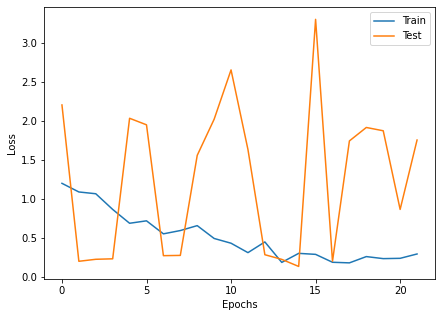

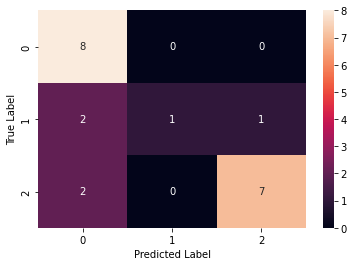

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.2071539078439986, Test Loss: 2.0340499877929688
Epoch 2-- Train Loss:1.0836104622909002, Test Loss: 2.0174427032470703
Epoch 3-- Train Loss:1.1070743912742251, Test Loss: 2.2599964141845703
Epoch 4-- Train Loss:0.8277014337834858, Test Loss: 0.2528311610221863
Epoch 5-- Train Loss:0.7971439063549042, Test Loss: 0.23871402442455292
Epoch 6-- Train Loss:0.6561222594408762, Test Loss: 2.1653270721435547
Epoch 7-- Train Loss:0.5300809297533262, Test Loss: 1.8686124086380005
Epoch 8-- Train Loss:0.48425885964007603, Test Loss: 0.3487872779369354
Epoch 9-- Train Loss:0.4011148860057195, Test Loss: 1.8279190063476562
Epoch 10-- Train Loss:0.28786326572299004, Test Loss: 0.22788949310779572
Epoch 11-- Train Loss:0.3957702173363595, Test Loss: 1.340086579322815
Epoch 12-- Train Loss:0.4925247578039056, Test Loss: 2.1879076957702637
Epoch 13-- Train Loss:0.26329097027579945, Test Loss: 1.95196533203125
Epoch 14-- Tra

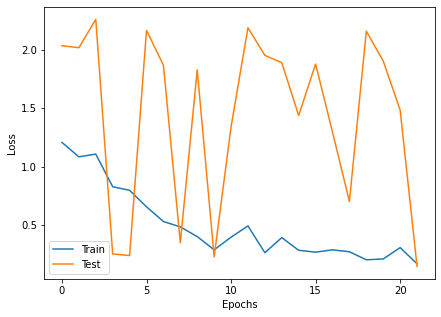

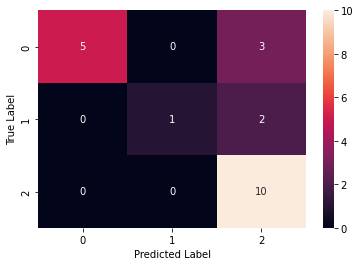

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.1987810390336173, Test Loss: 1.0806695222854614
Epoch 2-- Train Loss:1.1116227564357577, Test Loss: 1.381468653678894
Epoch 3-- Train Loss:0.968119257972354, Test Loss: 0.6198940873146057
Epoch 4-- Train Loss:0.951334087621598, Test Loss: 0.43442848324775696
Epoch 5-- Train Loss:0.6548629559221721, Test Loss: 0.8146583437919617
Epoch 6-- Train Loss:0.5443258768036252, Test Loss: 0.6504875421524048
Epoch 7-- Train Loss:0.4390412640003931, Test Loss: 1.0197614431381226
Epoch 8-- Train Loss:0.5080873299212683, Test Loss: 0.46317723393440247
Epoch 9-- Train Loss:0.3335792933191572, Test Loss: 0.4853144884109497
Epoch 10-- Train Loss:0.3422066603033316, Test Loss: 1.5024334192276
Epoch 11-- Train Loss:0.26579011373576666, Test Loss: 0.4730395972728729
Epoch 12-- Train Loss:0.30760418268896284, Test Loss: 1.4405609369277954
Epoch 13-- Train Loss:0.25420931198944646, Test Loss: 0.2810404896736145
Epoch 14-- Train 

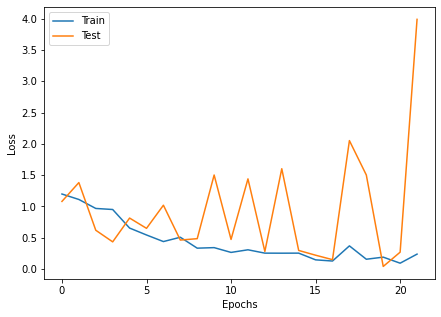

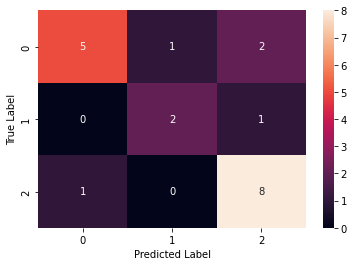

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.2592952194667997, Test Loss: 1.2903238534927368
Epoch 2-- Train Loss:1.1343025479997908, Test Loss: 1.7655563354492188
Epoch 3-- Train Loss:1.0550792728151595, Test Loss: 0.8980017304420471
Epoch 4-- Train Loss:0.8675294121106466, Test Loss: 0.41014978289604187
Epoch 5-- Train Loss:0.6637886819385347, Test Loss: 0.5676004886627197
Epoch 6-- Train Loss:0.6181056641397022, Test Loss: 1.954905390739441
Epoch 7-- Train Loss:0.4885049604234241, Test Loss: 0.6071312427520752
Epoch 8-- Train Loss:0.6217812729023752, Test Loss: 0.7669991254806519
Epoch 9-- Train Loss:0.43464477644080207, Test Loss: 0.7204041481018066
Epoch 10-- Train Loss:0.3008005132987386, Test Loss: 0.6634849905967712
Epoch 11-- Train Loss:0.22515127949771427, Test Loss: 0.2411498725414276
Epoch 12-- Train Loss:0.5352305252814576, Test Loss: 0.4718474745750427
Epoch 13-- Train Loss:0.12107090492333684, Test Loss: 0.7445306777954102
Epoch 14-- Tr

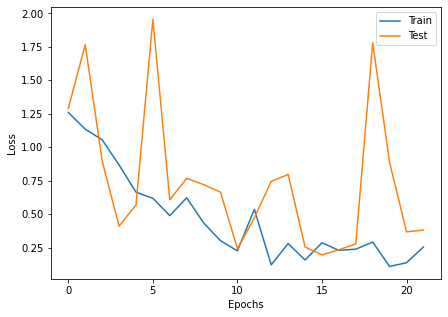

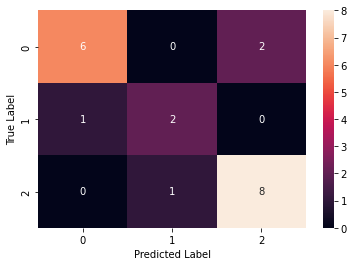

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1760194500287373, Test Loss: 0.9033979773521423
Epoch 2-- Train Loss:0.9936087301799229, Test Loss: 1.495811939239502
Epoch 3-- Train Loss:0.9213782492138091, Test Loss: 1.4894802570343018
Epoch 4-- Train Loss:0.7589426069032579, Test Loss: 0.43914544582366943
Epoch 5-- Train Loss:0.5509682581538246, Test Loss: 1.394498348236084
Epoch 6-- Train Loss:0.5730664432048798, Test Loss: 2.0049808025360107
Epoch 7-- Train Loss:0.5669483946902412, Test Loss: 2.5505764484405518
Epoch 8-- Train Loss:0.5481380898328054, Test Loss: 1.2842507362365723
Epoch 9-- Train Loss:0.3418313676402682, Test Loss: 0.8430456519126892
Epoch 10-- Train Loss:0.32357623481324743, Test Loss: 0.28684884309768677
Epoch 11-- Train Loss:0.2197297364473343, Test Loss: 0.6126766800880432
Epoch 12-- Train Loss:0.24797472623842104, Test Loss: 0.908211350440979
Epoch 13-- Train Loss:0.30961484116102966, Test Loss: 0.4011654853820801
Epoch 14-- Tra

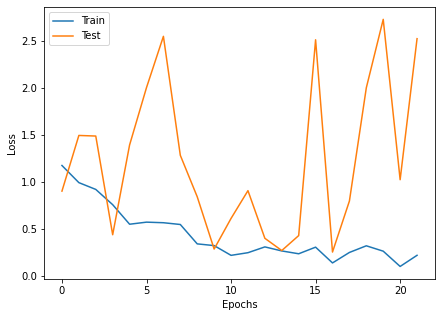

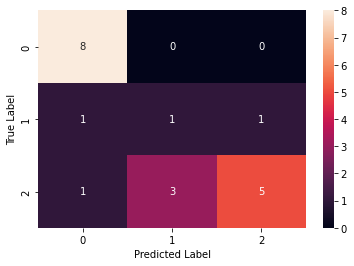

Starting testing
Training Complete
{'0': {'f1-score': '0.728±0.171',
       'precision': '0.729±0.168',
       'recall': '0.75±0.209',
       'support': 8},
 '1': {'f1-score': '0.387±0.254',
       'precision': '0.467±0.323',
       'recall': '0.333±0.211',
       'support': 4},
 '2': {'f1-score': '0.74±0.135',
       'precision': '0.73±0.146',
       'recall': '0.76±0.148',
       'support': 9},
 'accuracy': '0.688±0.143',
 'macro avg': {'f1-score': '0.618±0.151',
               'precision': '0.642±0.165',
               'recall': '0.614±0.141',
               'support': 21},
 'weighted avg': {'f1-score': '0.677±0.147',
                  'precision': '0.684±0.149',
                  'recall': '0.688±0.143',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.00501, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1530511054125698, Test Loss: 1.1088635921478271
Epoch 2-- Train Loss:1.0344583852724596, Test Loss: 0.5645973086357117
Epoch 3-- Train

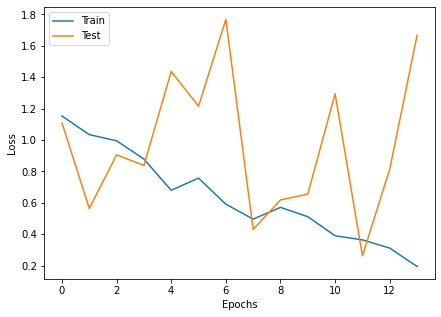

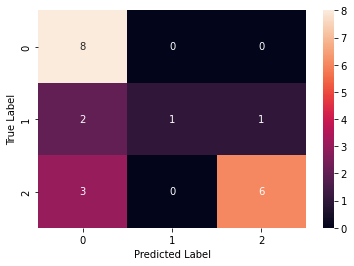

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.1510085409337825, Test Loss: 0.6026482582092285
Epoch 2-- Train Loss:1.057435387914831, Test Loss: 1.3325942754745483
Epoch 3-- Train Loss:0.9089590148492293, Test Loss: 2.0287389755249023
Epoch 4-- Train Loss:0.8095502582463351, Test Loss: 1.721955418586731
Epoch 5-- Train Loss:0.755222737789154, Test Loss: 1.7746869325637817
Epoch 6-- Train Loss:0.5569672178138386, Test Loss: 0.34815120697021484
Epoch 7-- Train Loss:0.6777741502631794, Test Loss: 1.5232088565826416
Epoch 8-- Train Loss:0.39227761192755267, Test Loss: 1.0182170867919922
Epoch 9-- Train Loss:0.46554681116884405, Test Loss: 1.0932444334030151
Epoch 10-- Train Loss:0.38168576156551187, Test Loss: 0.6248444318771362
Epoch 11-- Train Loss:0.44060489535331726, Test Loss: 0.4727315604686737
Epoch 12-- Train Loss:0.2175086411562833, Test Loss: 0.8948583006858826
Epoch 13-- Train Loss:0.2035084211013534, Test Loss: 1.3615531921386719
Epoch 14-- Tra

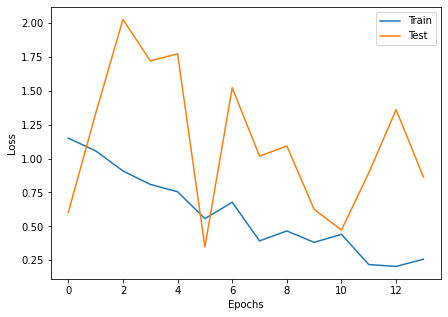

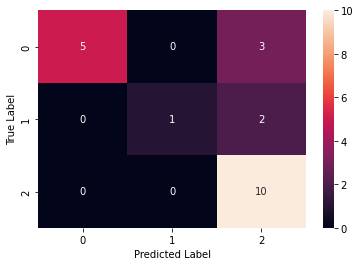

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.193471377546137, Test Loss: 1.746216893196106
Epoch 2-- Train Loss:1.1631421013311907, Test Loss: 1.754165530204773
Epoch 3-- Train Loss:1.093041409145702, Test Loss: 0.8318751454353333
Epoch 4-- Train Loss:0.8250365203077142, Test Loss: 1.4621868133544922
Epoch 5-- Train Loss:0.7214144576679576, Test Loss: 1.7117552757263184
Epoch 6-- Train Loss:0.5584681494669481, Test Loss: 1.2930454015731812
Epoch 7-- Train Loss:0.5113885971632871, Test Loss: 0.9839439988136292
Epoch 8-- Train Loss:0.4820731824094599, Test Loss: 2.683835983276367
Epoch 9-- Train Loss:0.3579193922606381, Test Loss: 1.7899665832519531
Epoch 10-- Train Loss:0.3462186435406858, Test Loss: 0.42308077216148376
Epoch 11-- Train Loss:0.24608060107989746, Test Loss: 0.22715289890766144
Epoch 12-- Train Loss:0.2951373735612089, Test Loss: 1.6499513387680054
Epoch 13-- Train Loss:0.3104633428156376, Test Loss: 0.36528345942497253
Epoch 14-- Train 

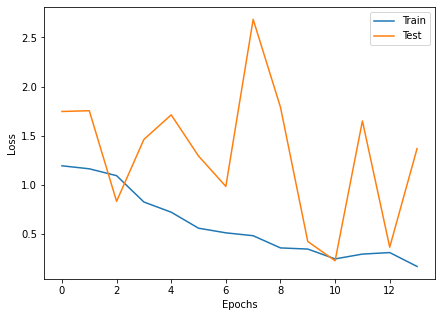

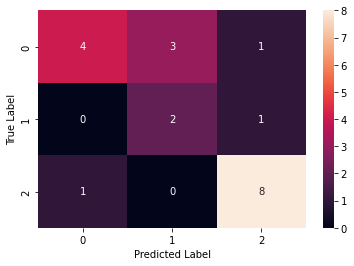

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1485988335175947, Test Loss: 1.0967538356781006
Epoch 2-- Train Loss:1.117010067809712, Test Loss: 0.8016013503074646
Epoch 3-- Train Loss:0.9973562576554038, Test Loss: 1.4420896768569946
Epoch 4-- Train Loss:0.788398948582736, Test Loss: 1.050295352935791
Epoch 5-- Train Loss:0.6743181483312086, Test Loss: 0.6894579529762268
Epoch 6-- Train Loss:0.5770216502926566, Test Loss: 1.5618177652359009
Epoch 7-- Train Loss:0.529722972349687, Test Loss: 1.086607575416565
Epoch 8-- Train Loss:0.4487467421726747, Test Loss: 0.5108628869056702
Epoch 9-- Train Loss:0.335230217738585, Test Loss: 0.37284302711486816
Epoch 10-- Train Loss:0.3458119651133364, Test Loss: 0.7205930352210999
Epoch 11-- Train Loss:0.2452889233827591, Test Loss: 0.49939870834350586
Epoch 12-- Train Loss:0.15582913905382156, Test Loss: 0.08089019358158112
Epoch 13-- Train Loss:0.3217697160487825, Test Loss: 0.9954216480255127
Epoch 14-- Train L

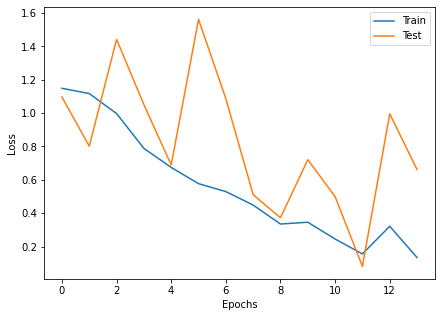

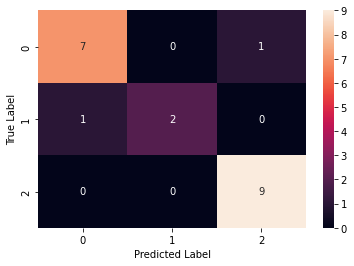

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1052799333225598, Test Loss: 1.0693891048431396
Epoch 2-- Train Loss:0.9958869869058783, Test Loss: 0.19061502814292908
Epoch 3-- Train Loss:0.8613316687670621, Test Loss: 0.9365376234054565
Epoch 4-- Train Loss:0.8024138754064386, Test Loss: 1.4680931568145752
Epoch 5-- Train Loss:0.6690457002683119, Test Loss: 1.739437222480774
Epoch 6-- Train Loss:0.4463294907049699, Test Loss: 0.4901461601257324
Epoch 7-- Train Loss:0.5245930498296564, Test Loss: 0.6445558667182922
Epoch 8-- Train Loss:0.47991257499564777, Test Loss: 1.0079147815704346
Epoch 9-- Train Loss:0.38774203576824884, Test Loss: 0.5400840640068054
Epoch 10-- Train Loss:0.2668686156923121, Test Loss: 1.6128904819488525
Epoch 11-- Train Loss:0.23227213255383752, Test Loss: 0.20068761706352234
Epoch 12-- Train Loss:0.1824643537402153, Test Loss: 0.5124484300613403
Epoch 13-- Train Loss:0.16973178495060315, Test Loss: 0.45440423488616943
Epoch 14--

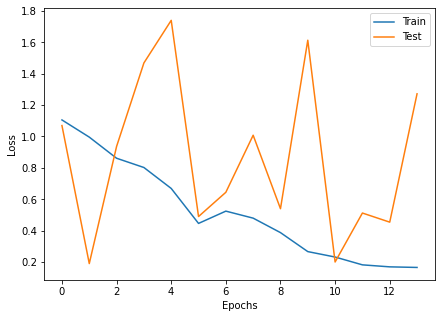

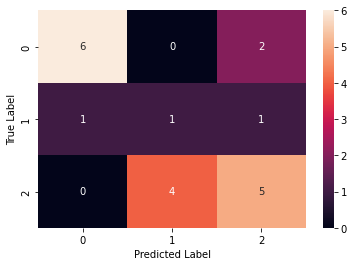

Starting testing
Training Complete
{'0': {'f1-score': '0.71±0.158',
       'precision': '0.813±0.14',
       'recall': '0.725±0.255',
       'support': 8},
 '1': {'f1-score': '0.471±0.195',
       'precision': '0.613±0.334',
       'recall': '0.45±0.18',
       'support': 4},
 '2': {'f1-score': '0.753±0.093',
       'precision': '0.807±0.155',
       'recall': '0.756±0.178',
       'support': 9},
 'accuracy': '0.697±0.092',
 'macro avg': {'f1-score': '0.645±0.114',
               'precision': '0.744±0.113',
               'recall': '0.644±0.11',
               'support': 21},
 'weighted avg': {'f1-score': '0.692±0.102',
                  'precision': '0.775±0.057',
                  'recall': '0.697±0.092',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.00401, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.138016939163208, Test Loss: 1.1468154191970825
Epoch 2-- Train Loss:1.092828591664632, Test Loss: 1.1326295137405396
Epoch 3-- Train L

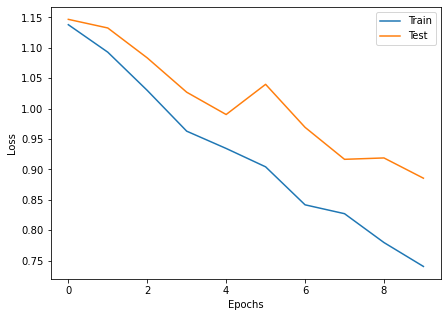

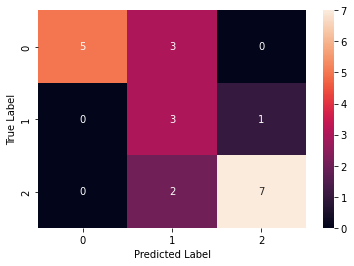

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.1477934122085571, Test Loss: 1.0831681489944458
Epoch 2-- Train Loss:1.067165454228719, Test Loss: 1.085731863975525
Epoch 3-- Train Loss:1.0984296798706055, Test Loss: 1.0866445302963257
Epoch 4-- Train Loss:1.0022118091583252, Test Loss: 1.0210204124450684
Epoch 5-- Train Loss:0.9786553581555685, Test Loss: 1.047154188156128
Epoch 6-- Train Loss:0.9322801232337952, Test Loss: 0.9701775908470154
Epoch 7-- Train Loss:0.8480581442515055, Test Loss: 0.9559826850891113
Epoch 8-- Train Loss:0.826318601767222, Test Loss: 0.9336664080619812
Epoch 9-- Train Loss:0.7995521624883016, Test Loss: 0.9487729668617249
Epoch 10-- Train Loss:0.7542834877967834, Test Loss: 0.8865220546722412


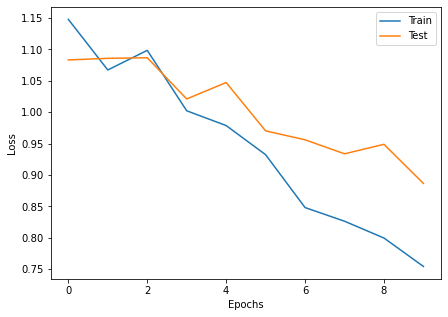

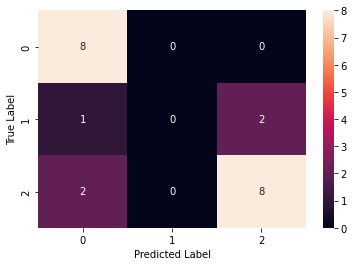

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.112801154454549, Test Loss: 1.093836784362793
Epoch 2-- Train Loss:1.0313057104746501, Test Loss: 1.053977370262146
Epoch 3-- Train Loss:0.9974664847056071, Test Loss: 1.0308455228805542
Epoch 4-- Train Loss:0.9522646069526672, Test Loss: 1.0149325132369995
Epoch 5-- Train Loss:0.9988268613815308, Test Loss: 1.0518081188201904
Epoch 6-- Train Loss:0.8816099365552267, Test Loss: 0.97503662109375
Epoch 7-- Train Loss:0.8214576840400696, Test Loss: 0.9427890777587891
Epoch 8-- Train Loss:0.8553266723950704, Test Loss: 0.9835261702537537
Epoch 9-- Train Loss:0.7591329216957092, Test Loss: 0.9103543758392334
Epoch 10-- Train Loss:0.7152820030848185, Test Loss: 0.889779269695282


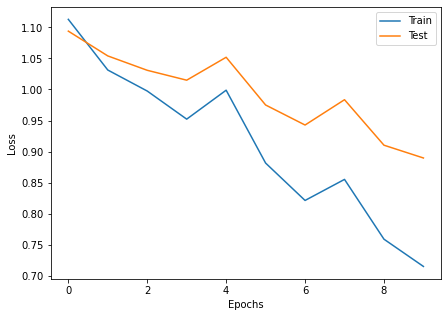

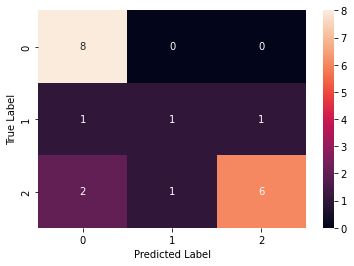

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.141164501508077, Test Loss: 1.0789659023284912
Epoch 2-- Train Loss:1.053105632464091, Test Loss: 1.0474398136138916
Epoch 3-- Train Loss:0.9939459562301636, Test Loss: 1.0268125534057617
Epoch 4-- Train Loss:0.9510427713394165, Test Loss: 1.0074234008789062
Epoch 5-- Train Loss:0.9938899079958597, Test Loss: 0.9464800953865051
Epoch 6-- Train Loss:0.8639071981112162, Test Loss: 0.9239875674247742
Epoch 7-- Train Loss:0.8437722126642863, Test Loss: 0.9064183235168457
Epoch 8-- Train Loss:0.821719765663147, Test Loss: 0.8802585601806641
Epoch 9-- Train Loss:0.7441434065500895, Test Loss: 0.8528547286987305
Epoch 10-- Train Loss:0.6980486114819845, Test Loss: 0.8153442144393921


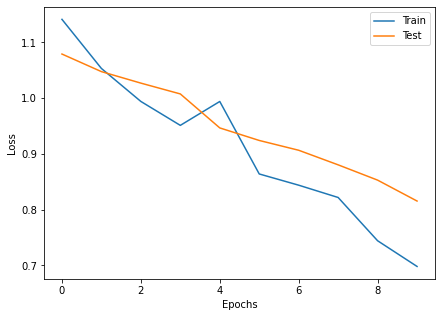

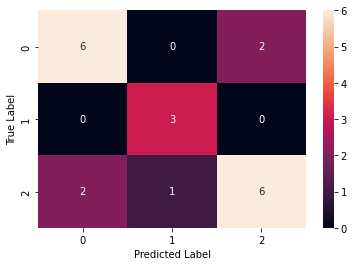

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.0910563866297405, Test Loss: 1.106201171875
Epoch 2-- Train Loss:1.0829851627349854, Test Loss: 1.069353461265564
Epoch 3-- Train Loss:1.0354139804840088, Test Loss: 1.1494041681289673
Epoch 4-- Train Loss:1.0029857158660889, Test Loss: 1.048596978187561
Epoch 5-- Train Loss:0.9230414827664694, Test Loss: 1.0406923294067383
Epoch 6-- Train Loss:0.8587300380071005, Test Loss: 1.0459904670715332
Epoch 7-- Train Loss:0.8653296828269958, Test Loss: 1.0016467571258545
Epoch 8-- Train Loss:0.8246332804361979, Test Loss: 0.9927684664726257
Epoch 9-- Train Loss:0.7453683416048685, Test Loss: 0.9954392313957214
Epoch 10-- Train Loss:0.7193923195203146, Test Loss: 1.0105668306350708


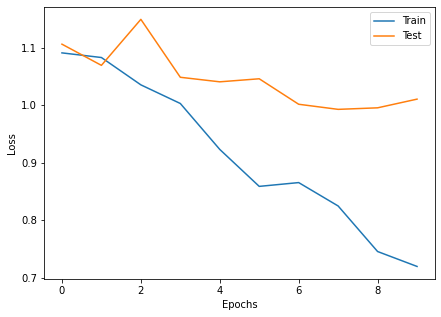

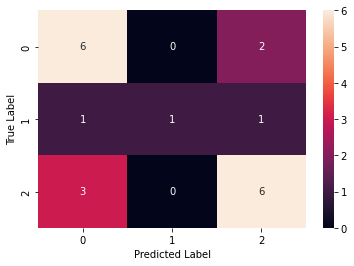

Starting testing
Training Complete
{'0': {'f1-score': '0.757±0.073',
       'precision': '0.754±0.131',
       'recall': '0.8±0.17',
       'support': 8},
 '1': {'f1-score': '0.494±0.321',
       'precision': '0.58±0.382',
       'recall': '0.533±0.4',
       'support': 4},
 '2': {'f1-score': '0.731±0.104',
       'precision': '0.787±0.163',
       'recall': '0.693±0.088',
       'support': 9},
 'accuracy': '0.715±0.087',
 'macro avg': {'f1-score': '0.661±0.118',
               'precision': '0.707±0.149',
               'recall': '0.676±0.119',
               'support': 21},
 'weighted avg': {'f1-score': '0.705±0.085',
                  'precision': '0.739±0.12',
                  'recall': '0.715±0.087',
                  'support': 21}}
{'num_epochs': 2, 'lr': 0.00701, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.146602749824524, Test Loss: 1.270499348640442
Epoch 2-- Train Loss:1.1213792562484741, Test Loss: 1.2044039964675903


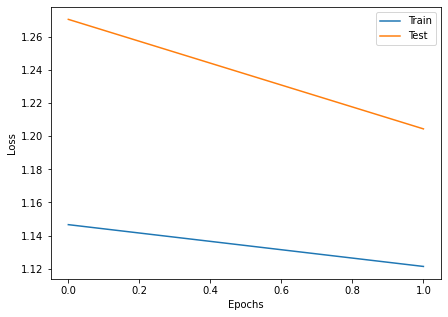

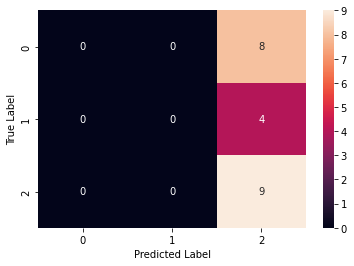

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.05751633644104, Test Loss: 1.0500413179397583
Epoch 2-- Train Loss:1.0646474758783977, Test Loss: 1.074942708015442


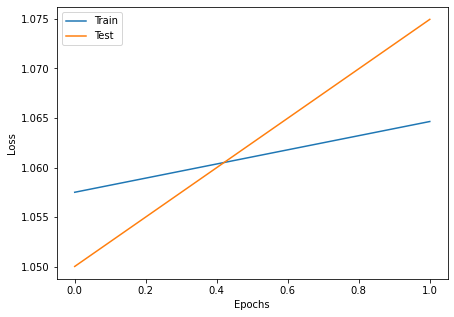

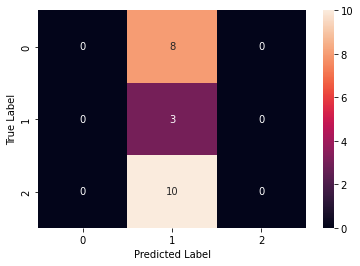

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0930206378300984, Test Loss: 1.1092956066131592
Epoch 2-- Train Loss:1.028540313243866, Test Loss: 1.046796202659607


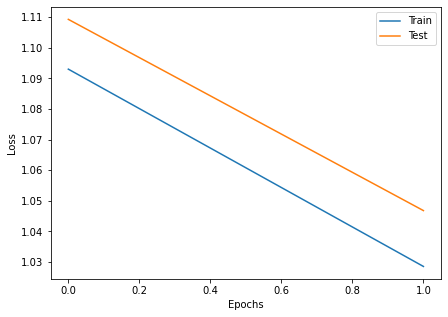

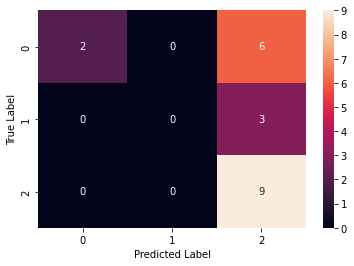

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1291919946670532, Test Loss: 1.0731693506240845
Epoch 2-- Train Loss:1.0733275810877483, Test Loss: 1.05244779586792


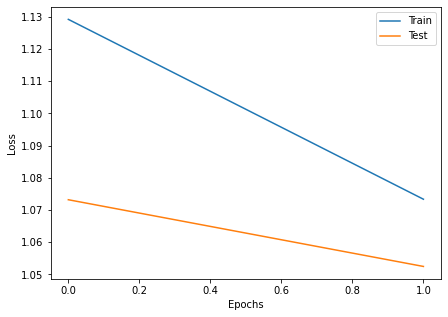

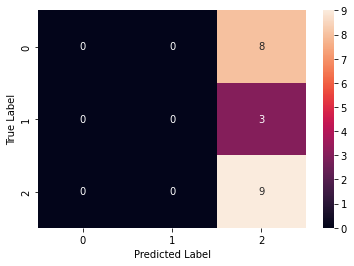

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1143712997436523, Test Loss: 1.1992748975753784
Epoch 2-- Train Loss:1.0386624733606975, Test Loss: 1.1870650053024292


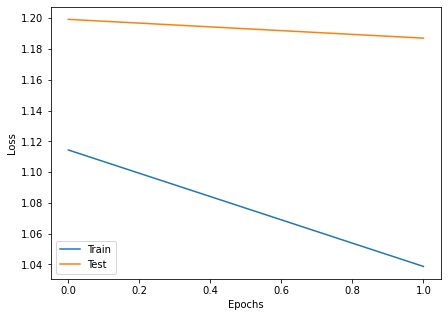

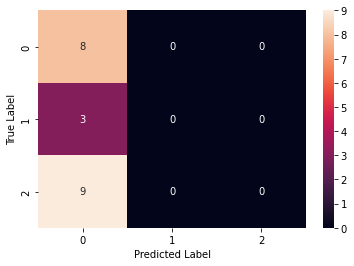

Starting testing
Training Complete
{'0': {'f1-score': '0.194±0.244',
       'precision': '0.28±0.392',
       'recall': '0.25±0.387',
       'support': 8},
 '1': {'f1-score': '0.05±0.1',
       'precision': '0.029±0.057',
       'recall': '0.2±0.4',
       'support': 4},
 '2': {'f1-score': '0.377±0.309',
       'precision': '0.276±0.226',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.394±0.135',
 'macro avg': {'f1-score': '0.207±0.087',
               'precision': '0.195±0.157',
               'recall': '0.35±0.033',
               'support': 21},
 'weighted avg': {'f1-score': '0.252±0.135',
                  'precision': '0.238±0.204',
                  'recall': '0.394±0.135',
                  'support': 21}}
{'num_epochs': 2, 'lr': 0.00201, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1182727018992107, Test Loss: 0.969245970249176
Epoch 2-- Train Loss:1.106103201707204, Test Loss: 0.7478598356246948


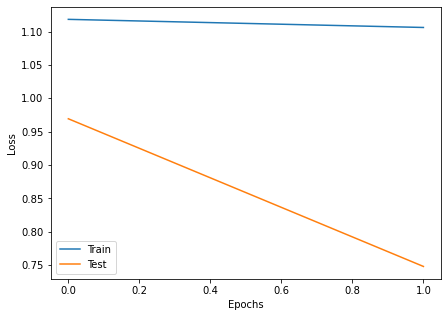

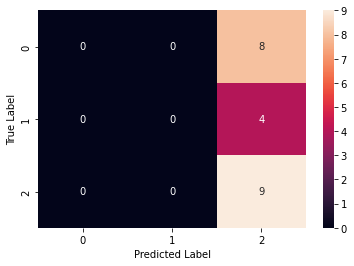

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.0691548387209575, Test Loss: 1.1534849405288696
Epoch 2-- Train Loss:1.085829774538676, Test Loss: 0.9348429441452026


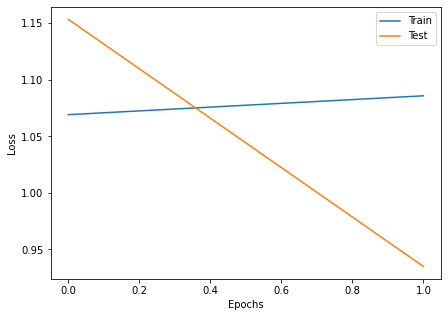

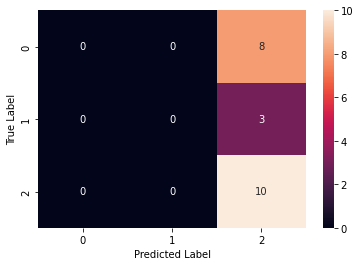

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0734043916066487, Test Loss: 0.943632185459137
Epoch 2-- Train Loss:1.1630797386169434, Test Loss: 0.9767383337020874


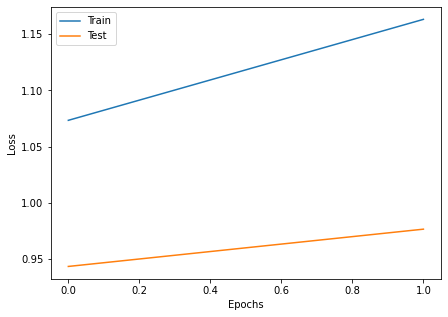

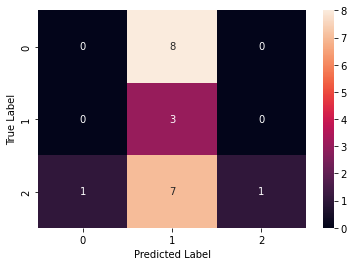

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1233586470286052, Test Loss: 1.04521906375885
Epoch 2-- Train Loss:1.092218816280365, Test Loss: 1.1383084058761597


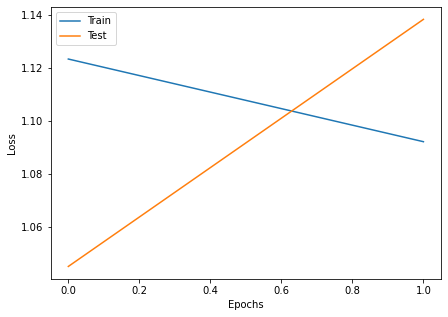

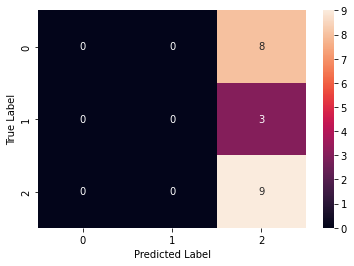

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1283771991729736, Test Loss: 1.292222261428833
Epoch 2-- Train Loss:1.1072057684262593, Test Loss: 1.1290982961654663


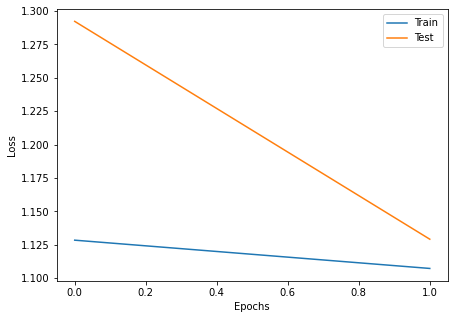

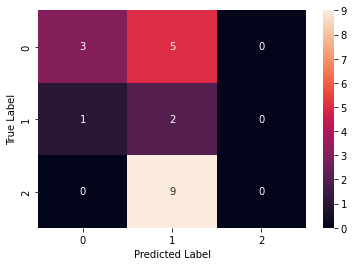

Starting testing
Training Complete
{'0': {'f1-score': '0.123±0.246',
       'precision': '0.16±0.32',
       'recall': '0.1±0.2',
       'support': 8},
 '1': {'f1-score': '0.102±0.125',
       'precision': '0.06±0.074',
       'recall': '0.333±0.422',
       'support': 4},
 '2': {'f1-score': '0.373±0.305',
       'precision': '0.271±0.222',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.361±0.122',
 'macro avg': {'f1-score': '0.199±0.062',
               'precision': '0.164±0.084',
               'recall': '0.344±0.022',
               'support': 21},
 'weighted avg': {'f1-score': '0.233±0.097',
                  'precision': '0.196±0.102',
                  'recall': '0.361±0.122',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.00101, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1259324777693975, Test Loss: 1.2411576509475708
Epoch 2-- Train Loss:1.0893286949112302, Test Loss: 0.6074484586715698
Epoch 3-- Train Loss:

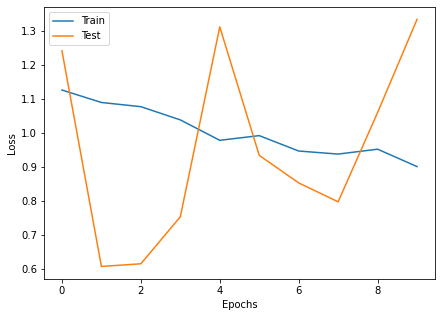

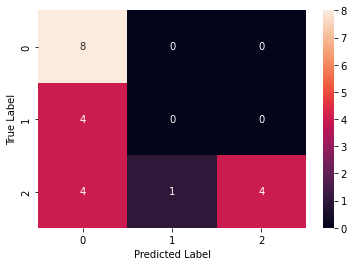

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.0942830187933785, Test Loss: 1.1672836542129517
Epoch 2-- Train Loss:1.0677089378947304, Test Loss: 1.1042739152908325
Epoch 3-- Train Loss:1.0634565296627225, Test Loss: 1.2277369499206543
Epoch 4-- Train Loss:1.012241990793319, Test Loss: 1.1472764015197754
Epoch 5-- Train Loss:0.9947945986475263, Test Loss: 0.6003537774085999
Epoch 6-- Train Loss:0.9614200223059881, Test Loss: 0.7370014786720276
Epoch 7-- Train Loss:0.9193893529119945, Test Loss: 1.674206018447876
Epoch 8-- Train Loss:0.9004173676172892, Test Loss: 0.6479318737983704
Epoch 9-- Train Loss:0.8992825831685748, Test Loss: 1.5403541326522827
Epoch 10-- Train Loss:0.8360772757303148, Test Loss: 0.6847802996635437


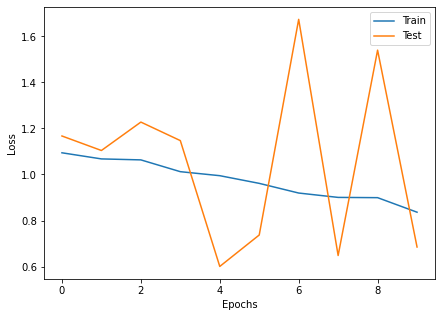

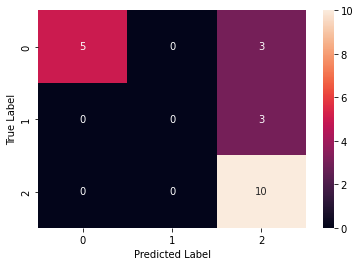

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.1116107730638414, Test Loss: 1.1850321292877197
Epoch 2-- Train Loss:1.045983842441014, Test Loss: 0.9707164168357849
Epoch 3-- Train Loss:1.0133936178116572, Test Loss: 0.79473477602005
Epoch 4-- Train Loss:0.9721761033648536, Test Loss: 0.8569585084915161
Epoch 5-- Train Loss:0.9498326920327687, Test Loss: 1.1466789245605469
Epoch 6-- Train Loss:0.9536304956390744, Test Loss: 0.9705265760421753
Epoch 7-- Train Loss:0.8925116345995948, Test Loss: 0.7625483870506287
Epoch 8-- Train Loss:0.8585721566563561, Test Loss: 0.7344818711280823
Epoch 9-- Train Loss:0.8666265039216905, Test Loss: 0.9965599179267883
Epoch 10-- Train Loss:0.8316178634053185, Test Loss: 0.808617353439331


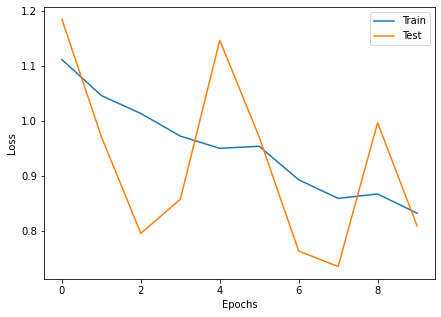

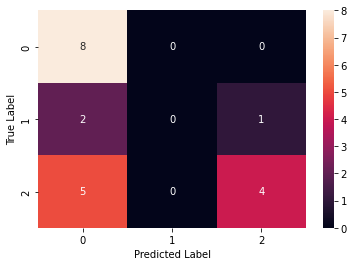

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.121922302813757, Test Loss: 1.0067970752716064
Epoch 2-- Train Loss:1.0670541326204936, Test Loss: 1.0679304599761963
Epoch 3-- Train Loss:1.0241742701757521, Test Loss: 1.0417684316635132
Epoch 4-- Train Loss:1.011724435147785, Test Loss: 0.9568137526512146
Epoch 5-- Train Loss:0.9613692987532843, Test Loss: 0.9348599314689636
Epoch 6-- Train Loss:0.923474595660255, Test Loss: 0.8023884296417236
Epoch 7-- Train Loss:0.951845699832553, Test Loss: 1.1292858123779297
Epoch 8-- Train Loss:0.9527696285928998, Test Loss: 0.9460567831993103
Epoch 9-- Train Loss:0.8596647410165696, Test Loss: 0.8225880861282349
Epoch 10-- Train Loss:0.8430969062305632, Test Loss: 0.9150492548942566


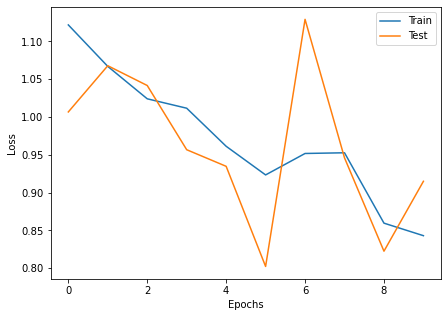

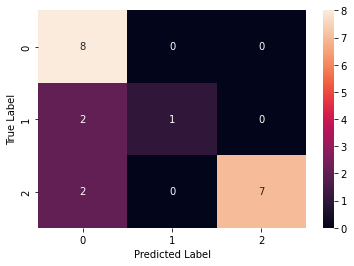

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1027892913137163, Test Loss: 0.9622557163238525
Epoch 2-- Train Loss:1.057226762885139, Test Loss: 1.2802050113677979
Epoch 3-- Train Loss:1.0079336308297657, Test Loss: 1.6420676708221436
Epoch 4-- Train Loss:1.007853042511713, Test Loss: 1.1852052211761475
Epoch 5-- Train Loss:0.9937878478141058, Test Loss: 1.1214021444320679
Epoch 6-- Train Loss:0.9608055523463658, Test Loss: 1.1058845520019531
Epoch 7-- Train Loss:0.9827367407935006, Test Loss: 1.2727046012878418
Epoch 8-- Train Loss:0.8784141767592657, Test Loss: 1.1883628368377686
Epoch 9-- Train Loss:0.8285249329748607, Test Loss: 1.0120378732681274
Epoch 10-- Train Loss:0.8475691278775533, Test Loss: 1.1413710117340088


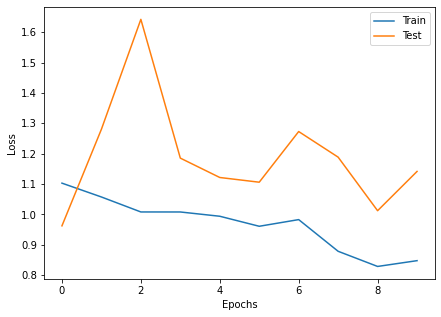

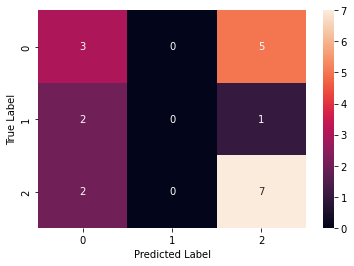

Starting testing
Training Complete
{'0': {'f1-score': '0.678±0.035',
       'precision': '0.673±0.173',
       'recall': '0.775±0.2',
       'support': 8},
 '1': {'f1-score': '0.2±0.245',
       'precision': '0.4±0.49',
       'recall': '0.133±0.163',
       'support': 4},
 '2': {'f1-score': '0.758±0.062',
       'precision': '0.802±0.178',
       'recall': '0.778±0.157',
       'support': 9},
 'accuracy': '0.677±0.058',
 'macro avg': {'f1-score': '0.546±0.101',
               'precision': '0.625±0.188',
               'recall': '0.562±0.067',
               'support': 21},
 'weighted avg': {'f1-score': '0.638±0.073',
                  'precision': '0.682±0.111',
                  'recall': '0.677±0.058',
                  'support': 21}}
{'num_epochs': 26, 'lr': 1e-05, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1569046378135681, Test Loss: 1.2124189138412476
Epoch 2-- Train Loss:1.1596914331118267, Test Loss: 1.2643229961395264
Epoch 3-- Train Los

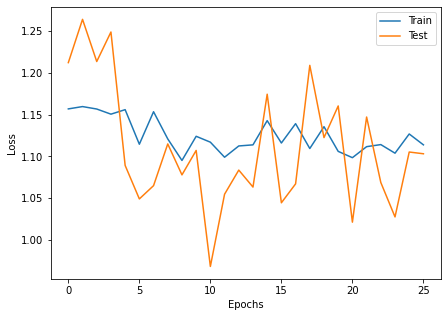

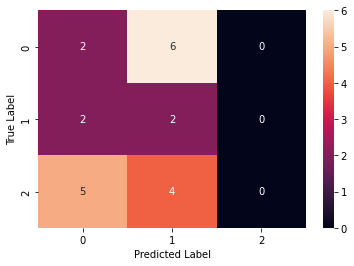

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.0897262593110402, Test Loss: 1.1677677631378174
Epoch 2-- Train Loss:1.093070516983668, Test Loss: 1.246741533279419
Epoch 3-- Train Loss:1.163775662581126, Test Loss: 1.1402943134307861
Epoch 4-- Train Loss:1.1586800416310628, Test Loss: 1.2967473268508911
Epoch 5-- Train Loss:1.1214273969332378, Test Loss: 1.119583010673523
Epoch 6-- Train Loss:1.0792304972807567, Test Loss: 0.9892342686653137
Epoch 7-- Train Loss:1.1141387422879536, Test Loss: 1.1071056127548218
Epoch 8-- Train Loss:1.093552052974701, Test Loss: 1.0419882535934448
Epoch 9-- Train Loss:1.1631381909052532, Test Loss: 0.9405911564826965
Epoch 10-- Train Loss:1.0803124010562897, Test Loss: 1.0889418125152588
Epoch 11-- Train Loss:1.1114774743715923, Test Loss: 1.0976756811141968
Epoch 12-- Train Loss:1.1444772481918335, Test Loss: 1.1301531791687012
Epoch 13-- Train Loss:1.1018989284833272, Test Loss: 1.1011476516723633
Epoch 14-- Train Loss

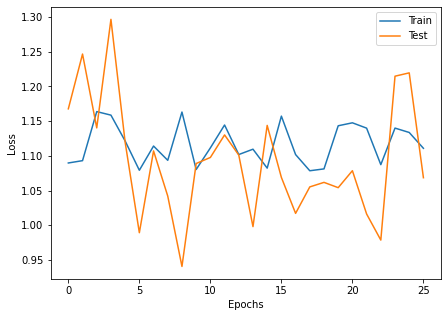

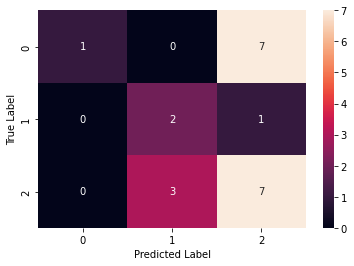

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.1021367410818736, Test Loss: 0.9421746730804443
Epoch 2-- Train Loss:1.0906170010566711, Test Loss: 0.7607734799385071
Epoch 3-- Train Loss:1.1672684748967488, Test Loss: 0.7989510297775269
Epoch 4-- Train Loss:1.1370031634966533, Test Loss: 1.0434355735778809
Epoch 5-- Train Loss:1.1532834966977437, Test Loss: 1.035922884941101
Epoch 6-- Train Loss:1.1958409647146861, Test Loss: 1.2263407707214355
Epoch 7-- Train Loss:1.1653956572214763, Test Loss: 1.3535960912704468
Epoch 8-- Train Loss:1.0640192031860352, Test Loss: 1.1763046979904175
Epoch 9-- Train Loss:1.1393094162146251, Test Loss: 0.9379869103431702
Epoch 10-- Train Loss:1.0962937970956166, Test Loss: 0.8745678663253784
Epoch 11-- Train Loss:1.1304844816525776, Test Loss: 0.8309199810028076
Epoch 12-- Train Loss:1.1413246989250183, Test Loss: 1.0403218269348145
Epoch 13-- Train Loss:1.1742672125498455, Test Loss: 1.2706464529037476
Epoch 14-- Train 

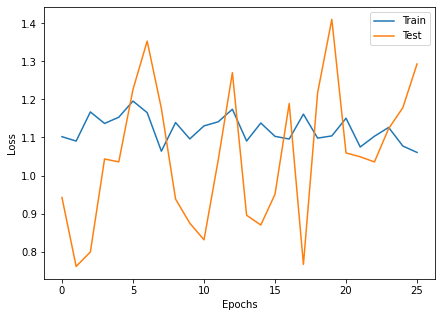

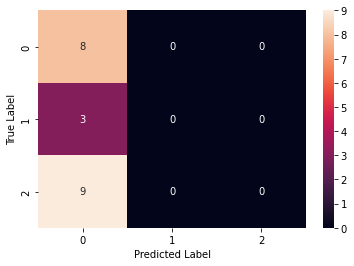

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.0830764472484589, Test Loss: 1.2498688697814941
Epoch 2-- Train Loss:1.0738921562830608, Test Loss: 1.2121108770370483
Epoch 3-- Train Loss:1.0781809488932292, Test Loss: 1.105868935585022
Epoch 4-- Train Loss:1.0953075885772705, Test Loss: 1.0397180318832397
Epoch 5-- Train Loss:1.1217329104741414, Test Loss: 1.1613733768463135
Epoch 6-- Train Loss:1.0800471305847168, Test Loss: 0.8802188038825989
Epoch 7-- Train Loss:1.133565346399943, Test Loss: 1.2205336093902588
Epoch 8-- Train Loss:1.0728573401769002, Test Loss: 1.1656771898269653
Epoch 9-- Train Loss:1.1239173412322998, Test Loss: 1.1755778789520264
Epoch 10-- Train Loss:1.1391770839691162, Test Loss: 0.870552122592926
Epoch 11-- Train Loss:1.0772967139879863, Test Loss: 0.868378221988678
Epoch 12-- Train Loss:1.0751496255397797, Test Loss: 0.9730550646781921
Epoch 13-- Train Loss:1.0904290080070496, Test Loss: 0.9962263703346252
Epoch 14-- Train Los

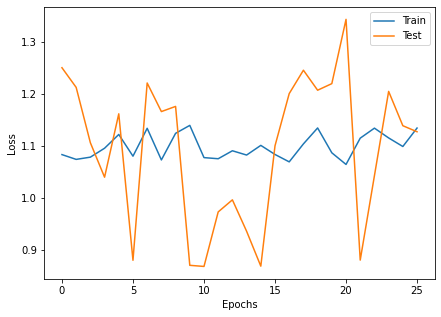

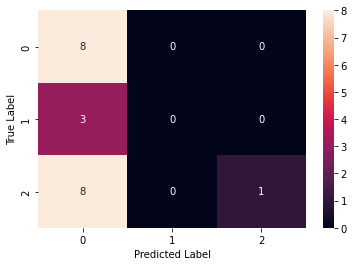

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1348050634066265, Test Loss: 1.2531098127365112
Epoch 2-- Train Loss:1.1332755088806152, Test Loss: 1.2814515829086304
Epoch 3-- Train Loss:1.0812898576259613, Test Loss: 1.012495756149292
Epoch 4-- Train Loss:1.0921045045057933, Test Loss: 1.0830968618392944
Epoch 5-- Train Loss:1.1343263785044353, Test Loss: 1.2027117013931274
Epoch 6-- Train Loss:1.1156553626060486, Test Loss: 1.1242748498916626
Epoch 7-- Train Loss:1.128053347269694, Test Loss: 1.04012131690979
Epoch 8-- Train Loss:1.0828711887200673, Test Loss: 1.2913873195648193
Epoch 9-- Train Loss:1.080496569474538, Test Loss: 0.9701310396194458
Epoch 10-- Train Loss:1.1011776328086853, Test Loss: 1.0971230268478394
Epoch 11-- Train Loss:1.1201711495717366, Test Loss: 1.2079863548278809
Epoch 12-- Train Loss:1.1173328161239624, Test Loss: 1.2852110862731934
Epoch 13-- Train Loss:1.0905357797940571, Test Loss: 1.2423460483551025
Epoch 14-- Train Loss

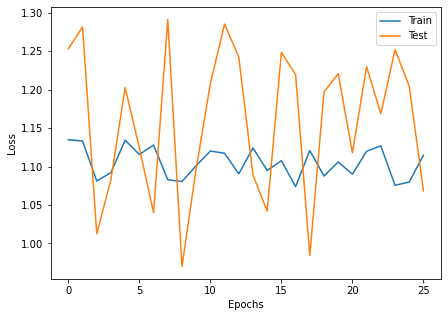

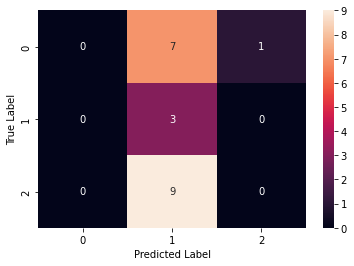

Starting testing
Training Complete
{'0': {'f1-score': '0.261±0.275',
       'precision': '0.191±0.194',
       'recall': '0.425±0.472',
       'support': 8},
 '1': {'f1-score': '0.206±0.21',
       'precision': '0.158±0.183',
       'recall': '0.367±0.306',
       'support': 4},
 '2': {'f1-score': '0.239±0.252',
       'precision': '0.373±0.373',
       'recall': '0.247±0.337',
       'support': 9},
 'accuracy': '0.343±0.166',
 'macro avg': {'f1-score': '0.236±0.115',
               'precision': '0.241±0.148',
               'recall': '0.346±0.111',
               'support': 21},
 'weighted avg': {'f1-score': '0.247±0.137',
                  'precision': '0.271±0.196',
                  'recall': '0.343±0.166',
                  'support': 21}}
{'num_epochs': 2, 'lr': 0.00901, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.129723792274793, Test Loss: 1.4887396097183228
Epoch 2-- Train Loss:1.191496988137563, Test Loss: 0.7712279558181763


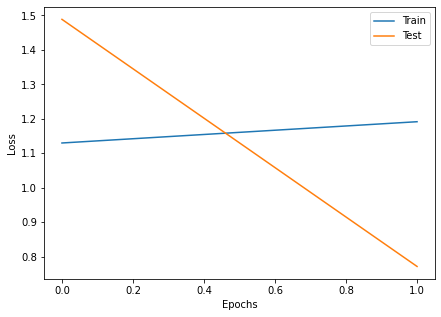

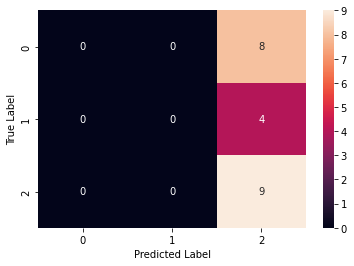

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:0.9746644993623098, Test Loss: 2.2766709327697754
Epoch 2-- Train Loss:1.1921211977799733, Test Loss: 1.5288039445877075


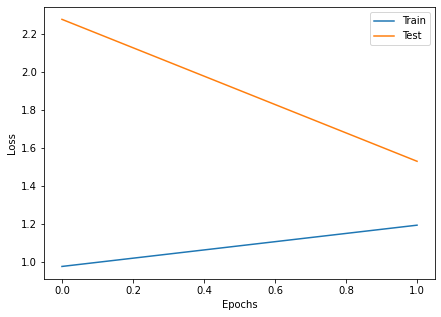

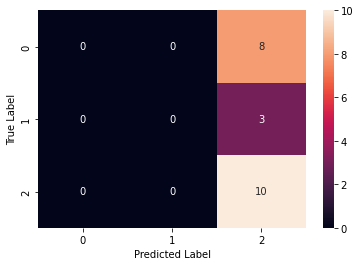

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0981704791386921, Test Loss: 0.6340604424476624
Epoch 2-- Train Loss:1.7240705490112305, Test Loss: 1.0340232849121094


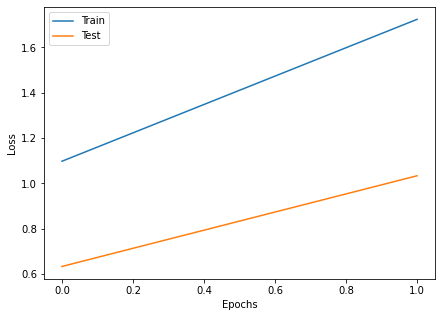

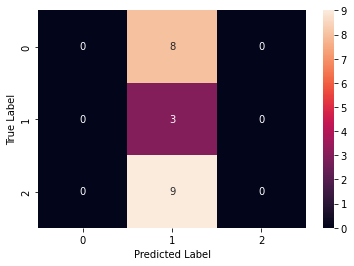

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1557881434758503, Test Loss: 2.11777400970459
Epoch 2-- Train Loss:1.241060475508372, Test Loss: 2.0981016159057617


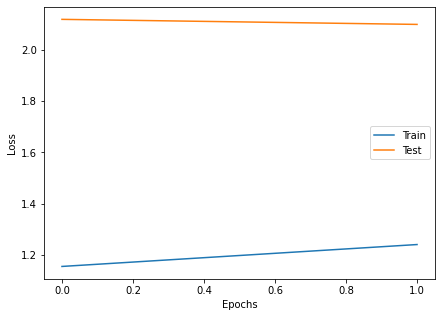

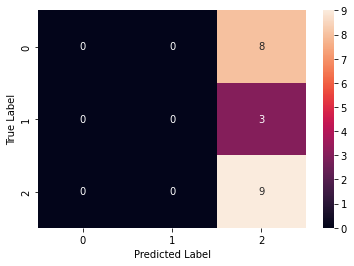

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.09683624903361, Test Loss: 2.421693801879883
Epoch 2-- Train Loss:1.3409274617830913, Test Loss: 1.619773507118225


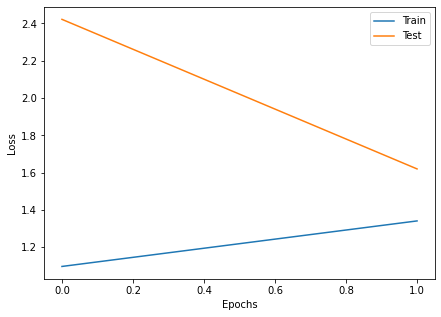

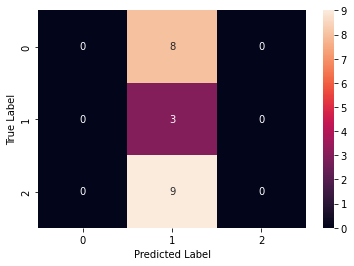

Starting testing
Training Complete
{'0': {'f1-score': '0.0±0.0',
       'precision': '0.0±0.0',
       'recall': '0.0±0.0',
       'support': 8},
 '1': {'f1-score': '0.104±0.128',
       'precision': '0.06±0.073',
       'recall': '0.4±0.49',
       'support': 4},
 '2': {'f1-score': '0.373±0.305',
       'precision': '0.271±0.222',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.331±0.149',
 'macro avg': {'f1-score': '0.159±0.059',
               'precision': '0.11±0.05',
               'recall': '0.333±0.0',
               'support': 21},
 'weighted avg': {'f1-score': '0.184±0.12',
                  'precision': '0.132±0.09',
                  'recall': '0.331±0.149',
                  'support': 21}}
{'num_epochs': 18, 'lr': 1e-05, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1569045782089233, Test Loss: 1.2124189138412476
Epoch 2-- Train Loss:1.1596914927164714, Test Loss: 1.2643229961395264
Epoch 3-- Train Loss:1.15675342082977

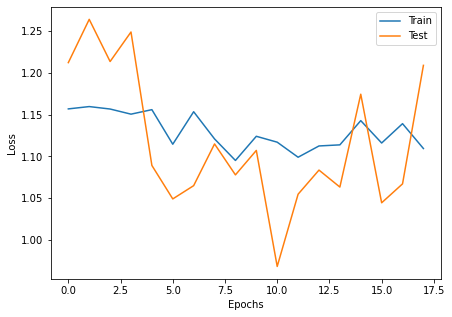

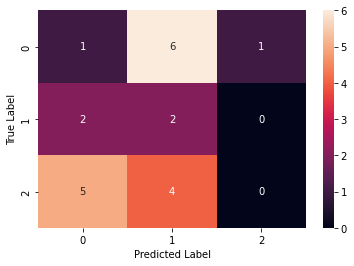

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.1017449796199799, Test Loss: 1.2787467241287231
Epoch 2-- Train Loss:1.1392760674158733, Test Loss: 1.1228049993515015
Epoch 3-- Train Loss:1.14850914478302, Test Loss: 1.1108866930007935
Epoch 4-- Train Loss:1.0868951578934987, Test Loss: 0.9816660284996033
Epoch 5-- Train Loss:1.0866232613722484, Test Loss: 1.0747150182724
Epoch 6-- Train Loss:1.0888983408610027, Test Loss: 1.142628788948059
Epoch 7-- Train Loss:1.0969931681950886, Test Loss: 1.0589007139205933
Epoch 8-- Train Loss:1.0874398251374562, Test Loss: 1.0811359882354736
Epoch 9-- Train Loss:1.1380128264427185, Test Loss: 1.06842041015625
Epoch 10-- Train Loss:1.1284488042195637, Test Loss: 0.9543859958648682
Epoch 11-- Train Loss:1.0829449693361919, Test Loss: 1.0279924869537354
Epoch 12-- Train Loss:1.087015450000763, Test Loss: 0.9339451789855957
Epoch 13-- Train Loss:1.1530860662460327, Test Loss: 1.1096794605255127
Epoch 14-- Train Loss:1.1

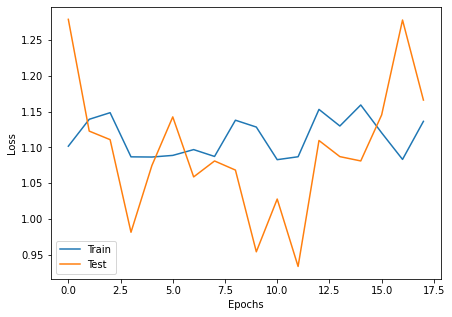

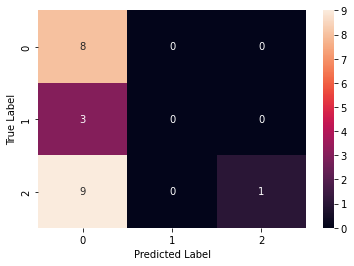

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.1094387769699097, Test Loss: 1.0437967777252197
Epoch 2-- Train Loss:1.1191386580467224, Test Loss: 0.984150767326355
Epoch 3-- Train Loss:1.1306818922360737, Test Loss: 1.1657181978225708
Epoch 4-- Train Loss:1.1093188921610515, Test Loss: 1.085951328277588
Epoch 5-- Train Loss:1.1051226456960042, Test Loss: 1.0501952171325684
Epoch 6-- Train Loss:1.1409345666567485, Test Loss: 1.0924947261810303
Epoch 7-- Train Loss:1.1210301518440247, Test Loss: 1.100858449935913
Epoch 8-- Train Loss:1.1409029165903728, Test Loss: 1.0472445487976074
Epoch 9-- Train Loss:1.1148981253306072, Test Loss: 1.048467993736267
Epoch 10-- Train Loss:1.133334477742513, Test Loss: 1.0332081317901611
Epoch 11-- Train Loss:1.1105339725812275, Test Loss: 0.9997649788856506
Epoch 12-- Train Loss:1.1467749277750652, Test Loss: 1.0736494064331055
Epoch 13-- Train Loss:1.1390772461891174, Test Loss: 1.1144335269927979
Epoch 14-- Train Loss

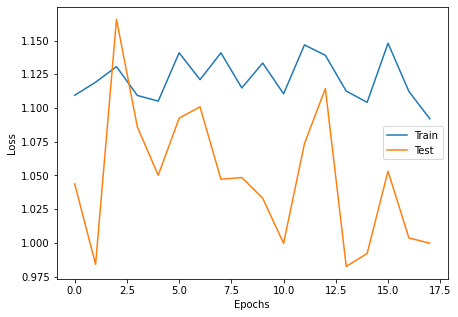

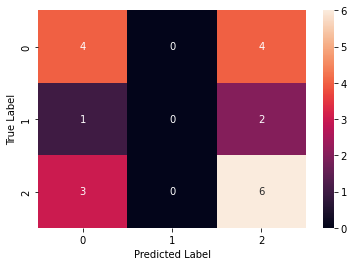

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1117969353993733, Test Loss: 0.9953809976577759
Epoch 2-- Train Loss:1.1046486298243205, Test Loss: 1.1137620210647583
Epoch 3-- Train Loss:1.1167901357014973, Test Loss: 1.0817011594772339
Epoch 4-- Train Loss:1.1236267288525899, Test Loss: 1.0862282514572144
Epoch 5-- Train Loss:1.112606942653656, Test Loss: 1.125393271446228
Epoch 6-- Train Loss:1.1262683073679607, Test Loss: 1.1111578941345215
Epoch 7-- Train Loss:1.1213308771451314, Test Loss: 1.0572497844696045


In [ ]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='resnet50'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

## 4.3 Big Transfer (BiT)



In [104]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-1, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(10,50, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 46, 'lr': 1e-05, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.5505791505177815, Test Loss: 0.8910125494003296
Epoch 2-- Train Loss:1.3143680691719055, Test Loss: 1.0368901491165161
Epoch 3-- Train Loss:1.332093060016632, Test Loss: 1.0564907789230347
Epoch 4-- Train Loss:1.2883259455362956, Test Loss: 1.4955886602401733
Epoch 5-- Train Loss:1.2358835935592651, Test Loss: 1.320107340812683
Epoch 6-- Train Loss:1.200642168521881, Test Loss: 1.2844548225402832
Epoch 7-- Train Loss:1.1744496424992878, Test Loss: 1.0976539850234985
Epoch 8-- Train Loss:1.161512811978658, Test Loss: 0.9447886347770691
Epoch 9-- Train Loss:1.1724517544110615, Test Loss: 0.774075448513031
Epoch 10-- Train Loss:1.1985118786493938, Test Loss: 0.9273928999900818
Epoch 11-- Train Loss:1.0325224002202351, Test Loss: 1.0672755241394043
Epoch 12-- Train Loss:1.1278744339942932, Test Loss: 0.8935931324958801


Exception ignored in: <function tqdm.__del__ at 0x7f655a4907b8>
Traceback (most recent call last):
  File "/home/gauthiers/.conda/envs/oro/lib/python3.7/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/gauthiers/.conda/envs/oro/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f655a4907b8>
Traceback (most recent call last):
  File "/home/gauthiers/.conda/envs/oro/lib/python3.7/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/gauthiers/.conda/envs/oro/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f655a4907b8>
Traceback (most recent call last):
  File "/home/gauthiers/.conda/envs

Epoch 13-- Train Loss:1.3160786926746368, Test Loss: 0.8997403383255005
Epoch 14-- Train Loss:1.2097819646199544, Test Loss: 1.252124547958374
Epoch 15-- Train Loss:1.1336323221524556, Test Loss: 1.0672085285186768
Epoch 16-- Train Loss:1.1342312097549438, Test Loss: 1.0328505039215088
Epoch 17-- Train Loss:1.0616367657979329, Test Loss: 1.117430567741394
Epoch 18-- Train Loss:1.1070313851038616, Test Loss: 0.9235345125198364
Epoch 19-- Train Loss:1.141482651233673, Test Loss: 0.9179567098617554
Epoch 20-- Train Loss:1.00449933608373, Test Loss: 1.078202724456787
Epoch 21-- Train Loss:1.0112852454185486, Test Loss: 1.1710535287857056
Epoch 22-- Train Loss:0.924044335881869, Test Loss: 1.2143012285232544
Epoch 23-- Train Loss:1.0586334466934204, Test Loss: 0.9055052995681763
Epoch 24-- Train Loss:0.9801519711812338, Test Loss: 1.2306865453720093
Epoch 25-- Train Loss:0.9615472853183746, Test Loss: 0.868736207485199
Epoch 26-- Train Loss:1.0302010973294575, Test Loss: 1.2075778245925903


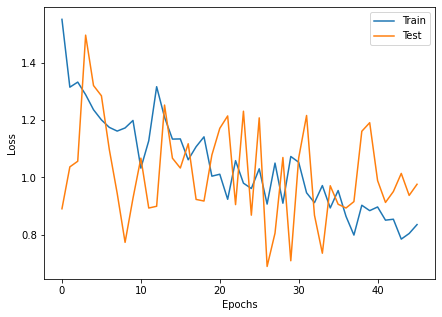

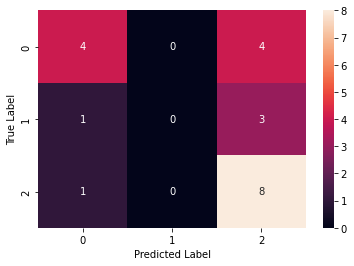

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.9433632095654805, Test Loss: 1.3889321088790894
Epoch 2-- Train Loss:1.4500749508539836, Test Loss: 0.7454928755760193
Epoch 3-- Train Loss:1.5371462504069011, Test Loss: 1.9084287881851196
Epoch 4-- Train Loss:1.3048476725816727, Test Loss: 1.6169370412826538
Epoch 5-- Train Loss:1.467674434185028, Test Loss: 0.9987146258354187
Epoch 6-- Train Loss:1.2820728619893391, Test Loss: 1.445839285850525
Epoch 7-- Train Loss:1.1465891599655151, Test Loss: 1.3505886793136597
Epoch 8-- Train Loss:1.3392399946848552, Test Loss: 1.315815806388855
Epoch 9-- Train Loss:1.1441782017548878, Test Loss: 1.522064447402954
Epoch 10-- Train Loss:1.2028698126475017, Test Loss: 1.2073819637298584
Epoch 11-- Train Loss:1.0607728163401287, Test Loss: 1.3870502710342407
Epoch 12-- Train Loss:1.1337022980054219, Test Loss: 1.3210529088974
Epoch 13-- Train Loss:1.1294455329577129, Test Loss: 0.9734172821044922
Epoch 14-- Train Loss:1

KeyboardInterrupt: 

In [103]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='bit'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

## 4.4 Parametric Scattering Network

In [107]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-5,1e-2, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(10,50, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


In [108]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='scattering'
    results = train_model(name=name, dataset=dataset, k_folds =5,  **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

{'num_epochs': 46, 'lr': 1e-05, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:0.9663238525390625, Test Loss: 1.1445127725601196
Epoch 2-- Train Loss:0.8974922696749369, Test Loss: 0.9095592498779297
Epoch 3-- Train Loss:0.75362096230189, Test Loss: 0.7695978283882141


KeyboardInterrupt: 

# 5. Access Metrics using Mlflow and DAGsHub

In [17]:
display(IPython.display.IFrame(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}/experiments/#/",'100%',600))